In [34]:
import networkx as nx
import os
import networkx as nx
from node2vec import Node2Vec
from helper_functions import read_net
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from collections import Counter
import math
import json
from adjustText import adjust_text
from collections import defaultdict

In [137]:
with open("../data/title_to_id_map.json", "r") as f:
    title_to_id_map = json.loads(f.read())

with open("../data/id_to_title_map.json", "r") as f:
    id_to_title_map = json.loads(f.read())

In [3]:
filename = "wikilinks_ids"
folder = os.path.join("..", "data")

In [82]:
G = read_net(folder, filename)

In [49]:
pr = nx.pagerank(G, alpha=0.9)

In [253]:
EMBEDDING_FILENAME = os.path.join("..", "data", "wikilinks.emb")
embeddings = np.genfromtxt(EMBEDDING_FILENAME, delimiter=',')

In [254]:
sizes = np.array(list(pr.values()))
colors = np.array(list(pr.values()))
h = 50
l = 0
sizes = (sizes - min(sizes)) / (max(sizes) - min(sizes)) * (h - l) + l
sizes = sizes**2

In [263]:
def plot_pca_2d(embeddings, sizes, colors, filename):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(embeddings)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    
    fig = plt.figure(figsize = (12,12), facecolor="white", dpi=200)
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], s=sizes, c=colors, cmap=plt.cm.coolwarm)
    plt.savefig("../img/" + filename, bbox_inches="tight", dpi=200)
    plt.show()

In [264]:
def plot_pca_3d(embeddings, sizes, colors, filename):
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(embeddings)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

    fig = plt.figure(figsize = (12,12), facecolor='white', dpi=200)
    ax = fig.add_subplot(projection='3d') 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('3 component PCA', fontsize = 20)

    ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], principalDf['principal component 3'], s=sizes, c=colors, cmap=plt.cm.coolwarm)
    ax.view_init(20, 90)
    plt.savefig("../img/" + filename, bbox_inches="tight", dpi=200)
    plt.show()

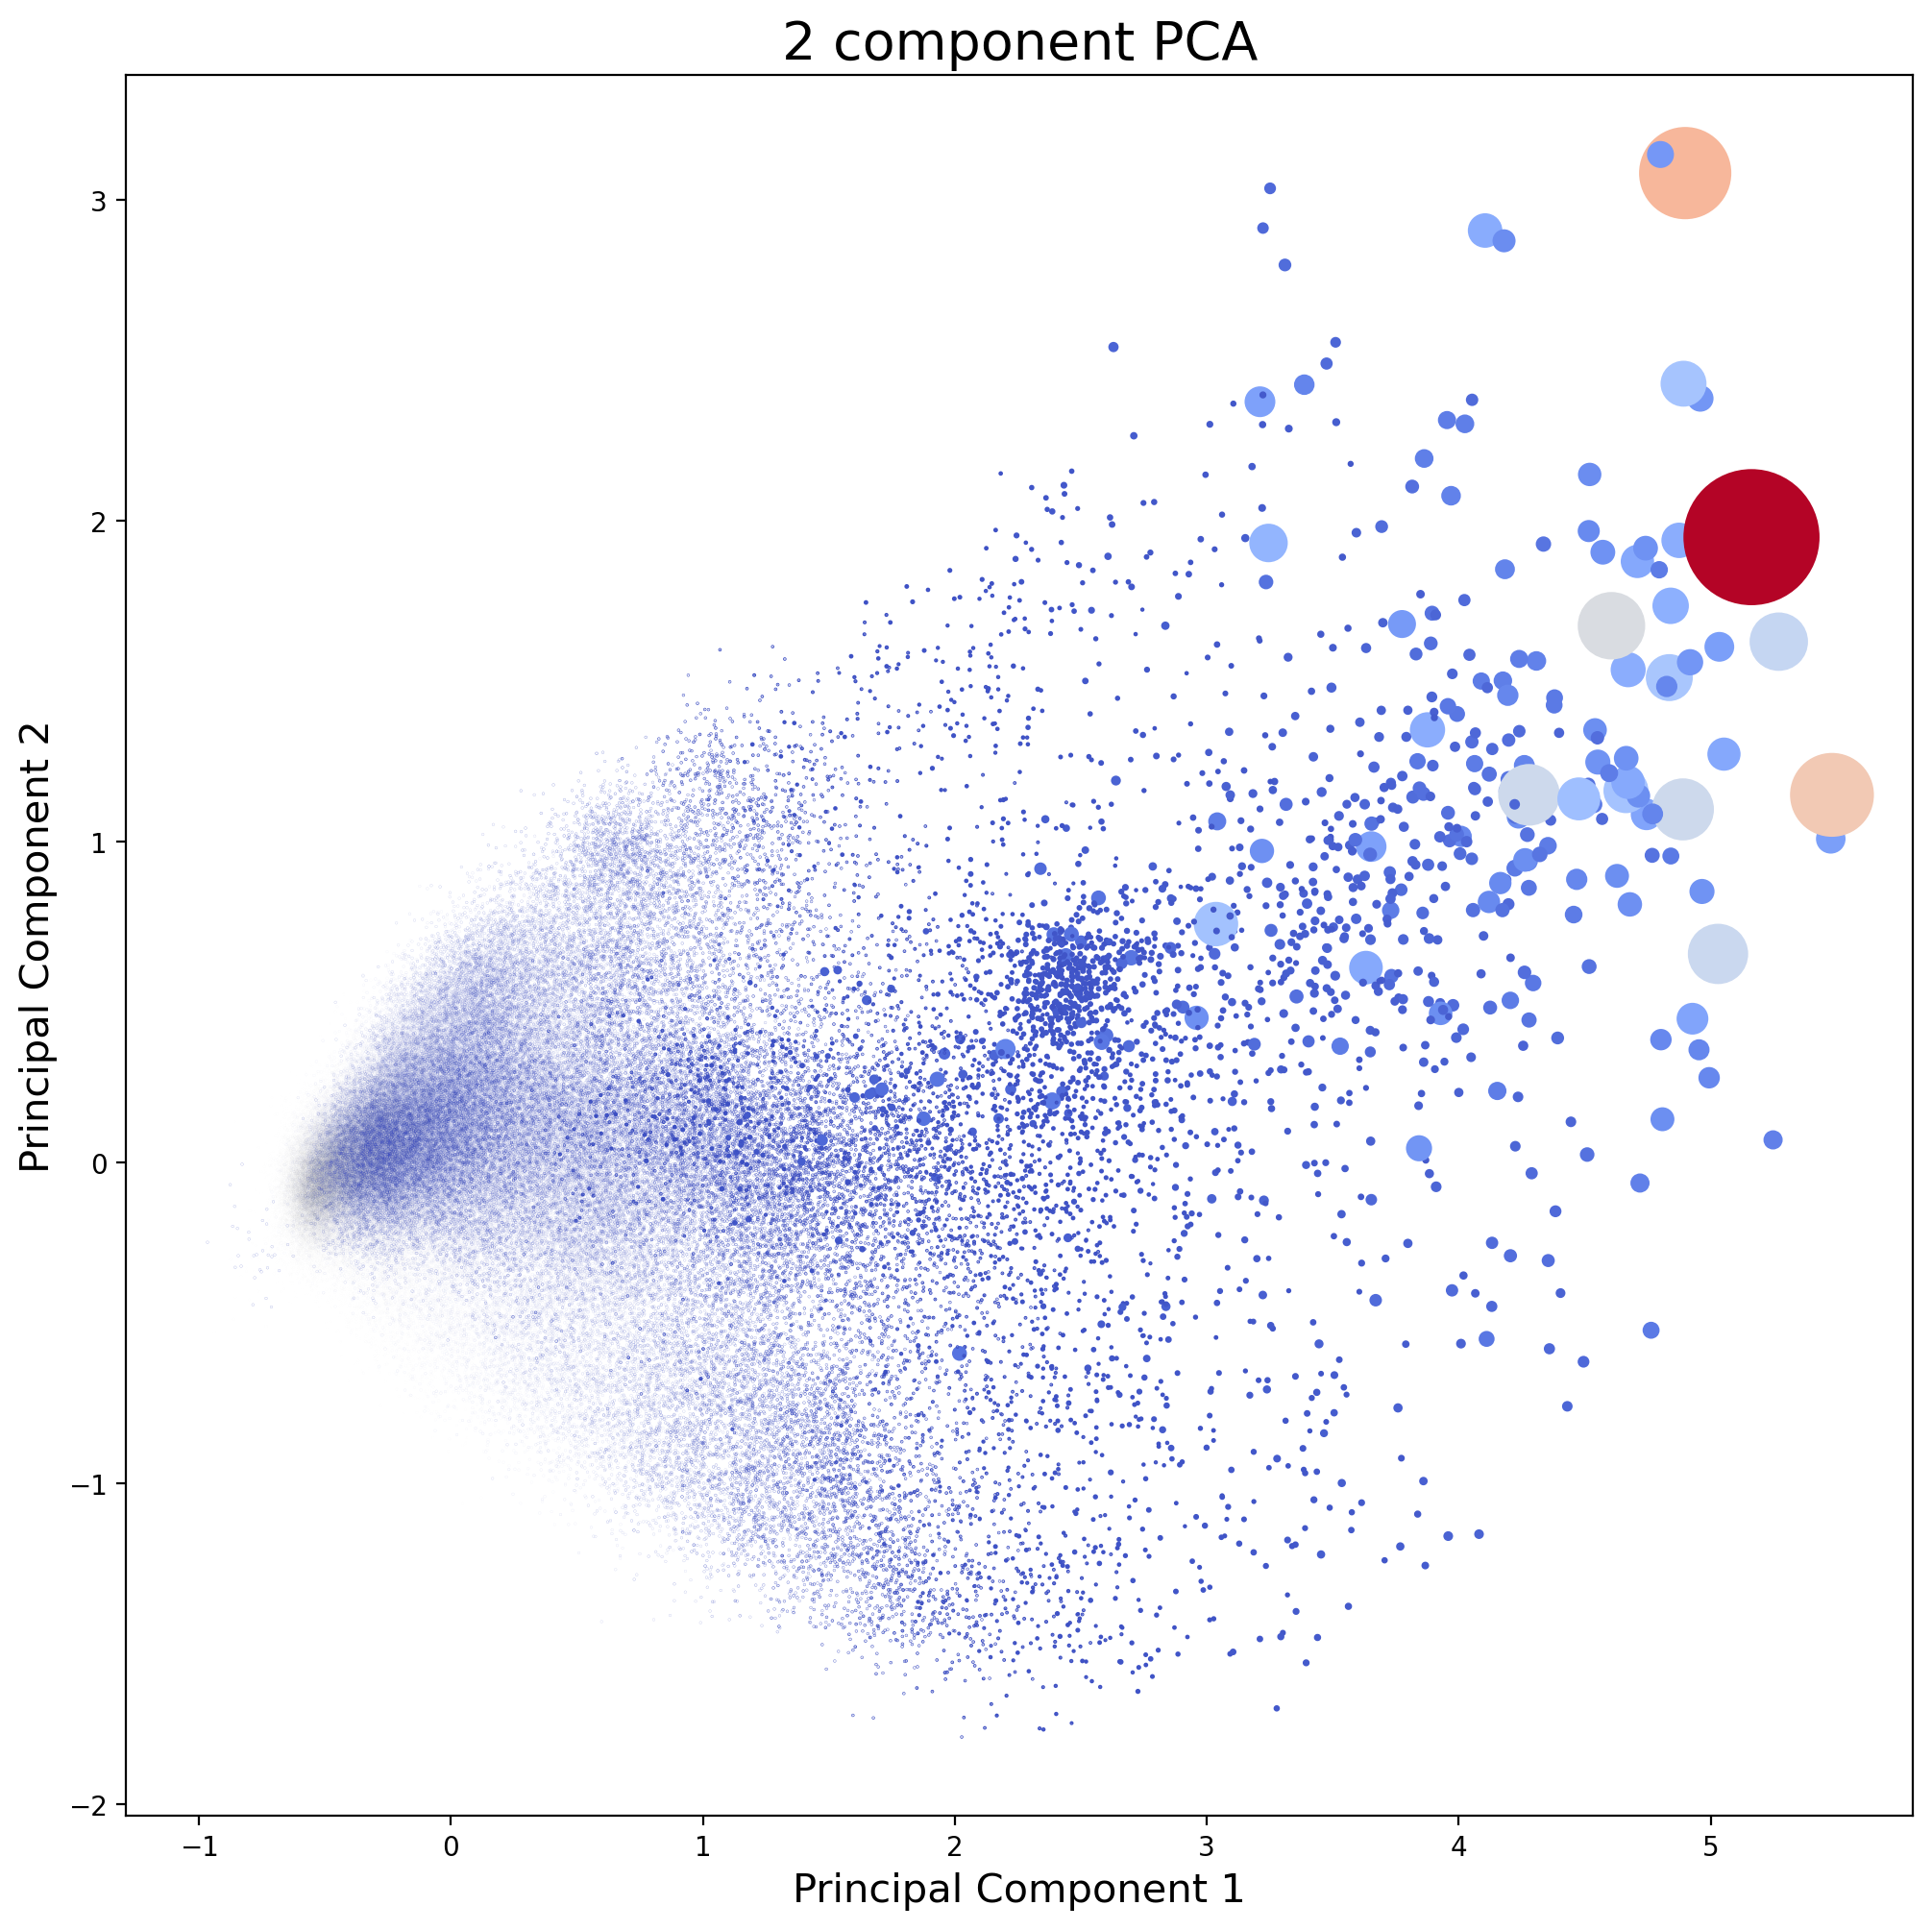

In [257]:
plot_pca_2d(embeddings, sizes, colors, "pca.png")

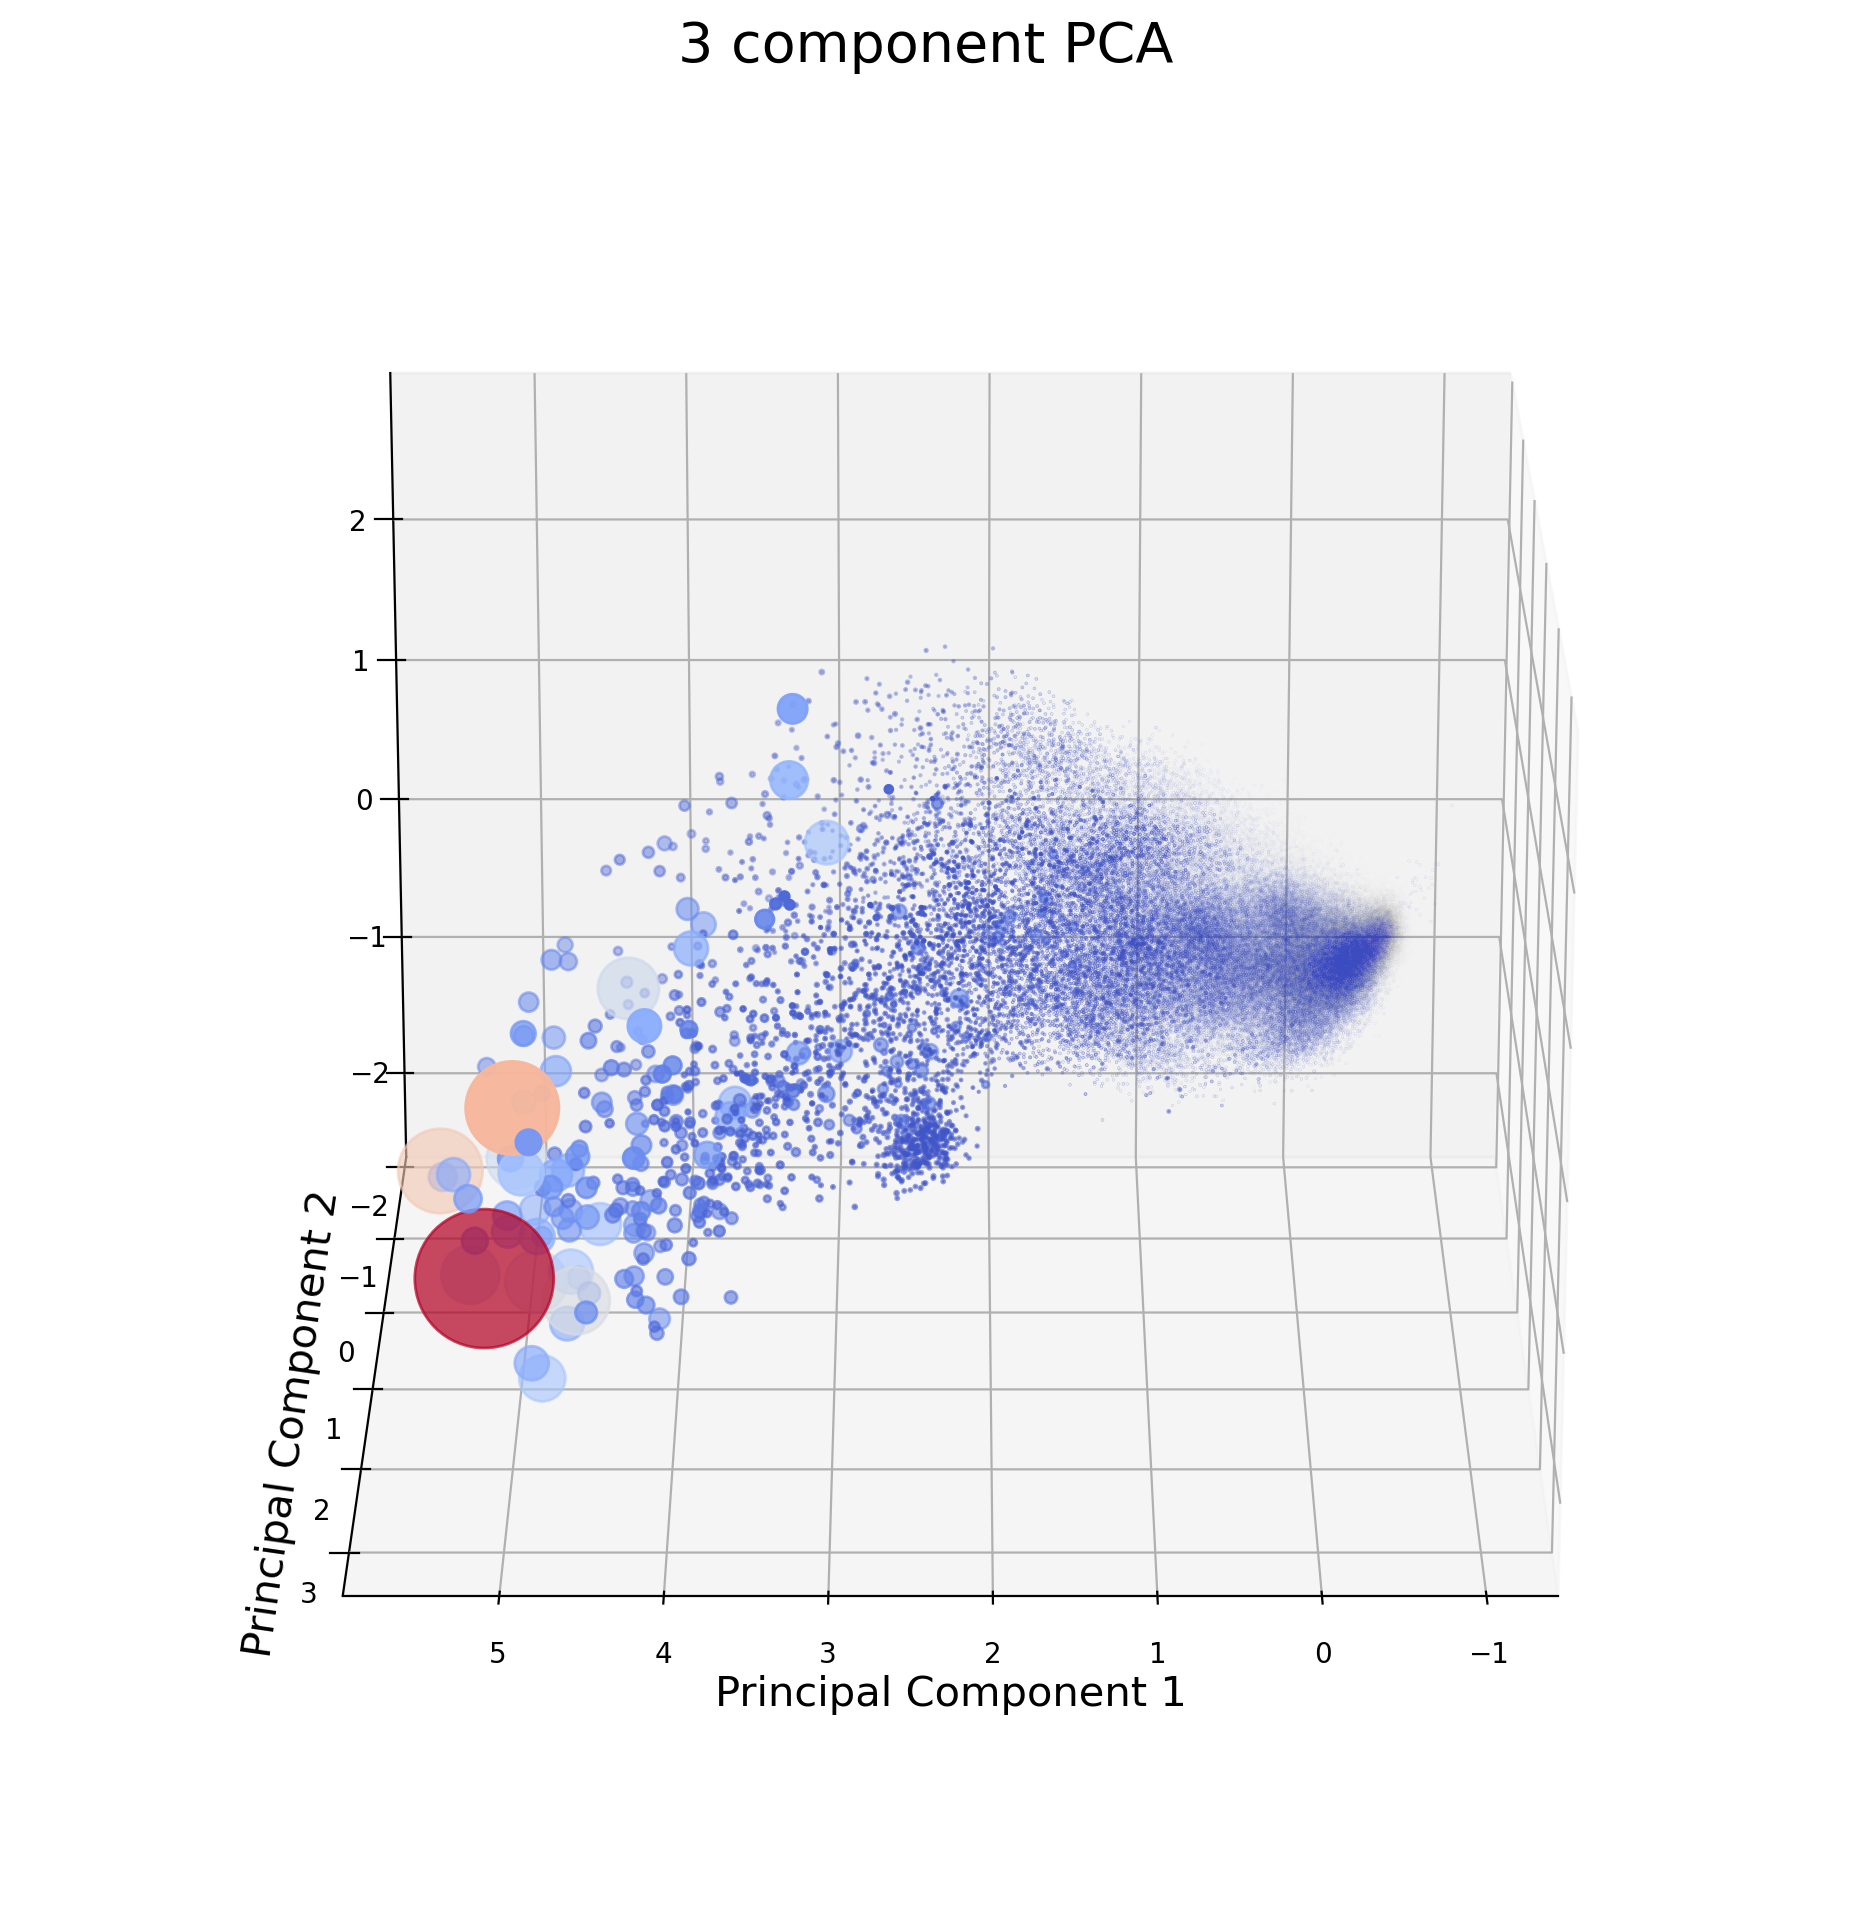

In [258]:
plot_pca_3d(embeddings, sizes, colors, "pca3d.png")

In [168]:
def calculate_degrees(G, degree_list):
    degree_list = sorted([i for i in degree_list if i != 0])

    degree_dict = Counter(degree_list)
    k = list(degree_dict.keys())
    Pk = [i / G.number_of_nodes() for i in degree_dict.values()]

    return k, Pk


def calculate_y(G, degrees, k_min = 1):
    n = 0
    sum_k = 0
    for _, k in degrees:
        if k >= k_min:
            sum_k += math.log(k / (k_min - 1/2))
            n += 1
    return 1 + n/sum_k

In [222]:
def plot_distributions(G, filename):
    # Calculate all degrees
    x, y = calculate_degrees(G, list(dict(G.degree).values()))
    x_in, y_in = calculate_degrees(G, list(dict(G.in_degree).values()))
    x_out, y_out = calculate_degrees(G, list(dict(G.out_degree).values()))

    fig, axs = plt.subplots(2, 2, figsize=(15,8), dpi=300, facecolor="white")

    color = ["#ff71ce", "#01cdfe", "#05ffa1", "#b967ff", "#fffb96"]

    # All degrees
    axs[0][0].loglog(x, y, "o", label='Wikilinks', color=color[0], alpha=0.7)
    axs[0][1].loglog(x, y, "o", label='Wikilinks', color=color[0], alpha=0.7)

    # Seperated degrees
    axs[0][0].loglog(x_in, y_in, "o", label='Wikilinks indegree', color=color[1], alpha=0.7)
    axs[1][0].loglog(x_in, y_in, "o", label='Wikilinks indegree', color=color[1], alpha=0.7)
    
    axs[0][0].loglog(x_out, y_out, "o", label='Wikilinks outdegree', color=color[2], alpha=0.7)
    axs[1][1].loglog(x_out, y_out, "o", label='Wikilinks outdegree', color=color[2], alpha=0.7)

    # Set labels and legend
    # axs = [ax11]
    for i in axs:
        for ax in i:
            ax.set_xlabel("k")
            ax.set_ylabel("Pk")
            ax.legend()

    # Saving and showing fig
    plt.subplots_adjust(wspace=0.15, hspace=0.1)
    plt.savefig("../img/" + filename, facecolor='white', bbox_inches="tight")
    plt.show()

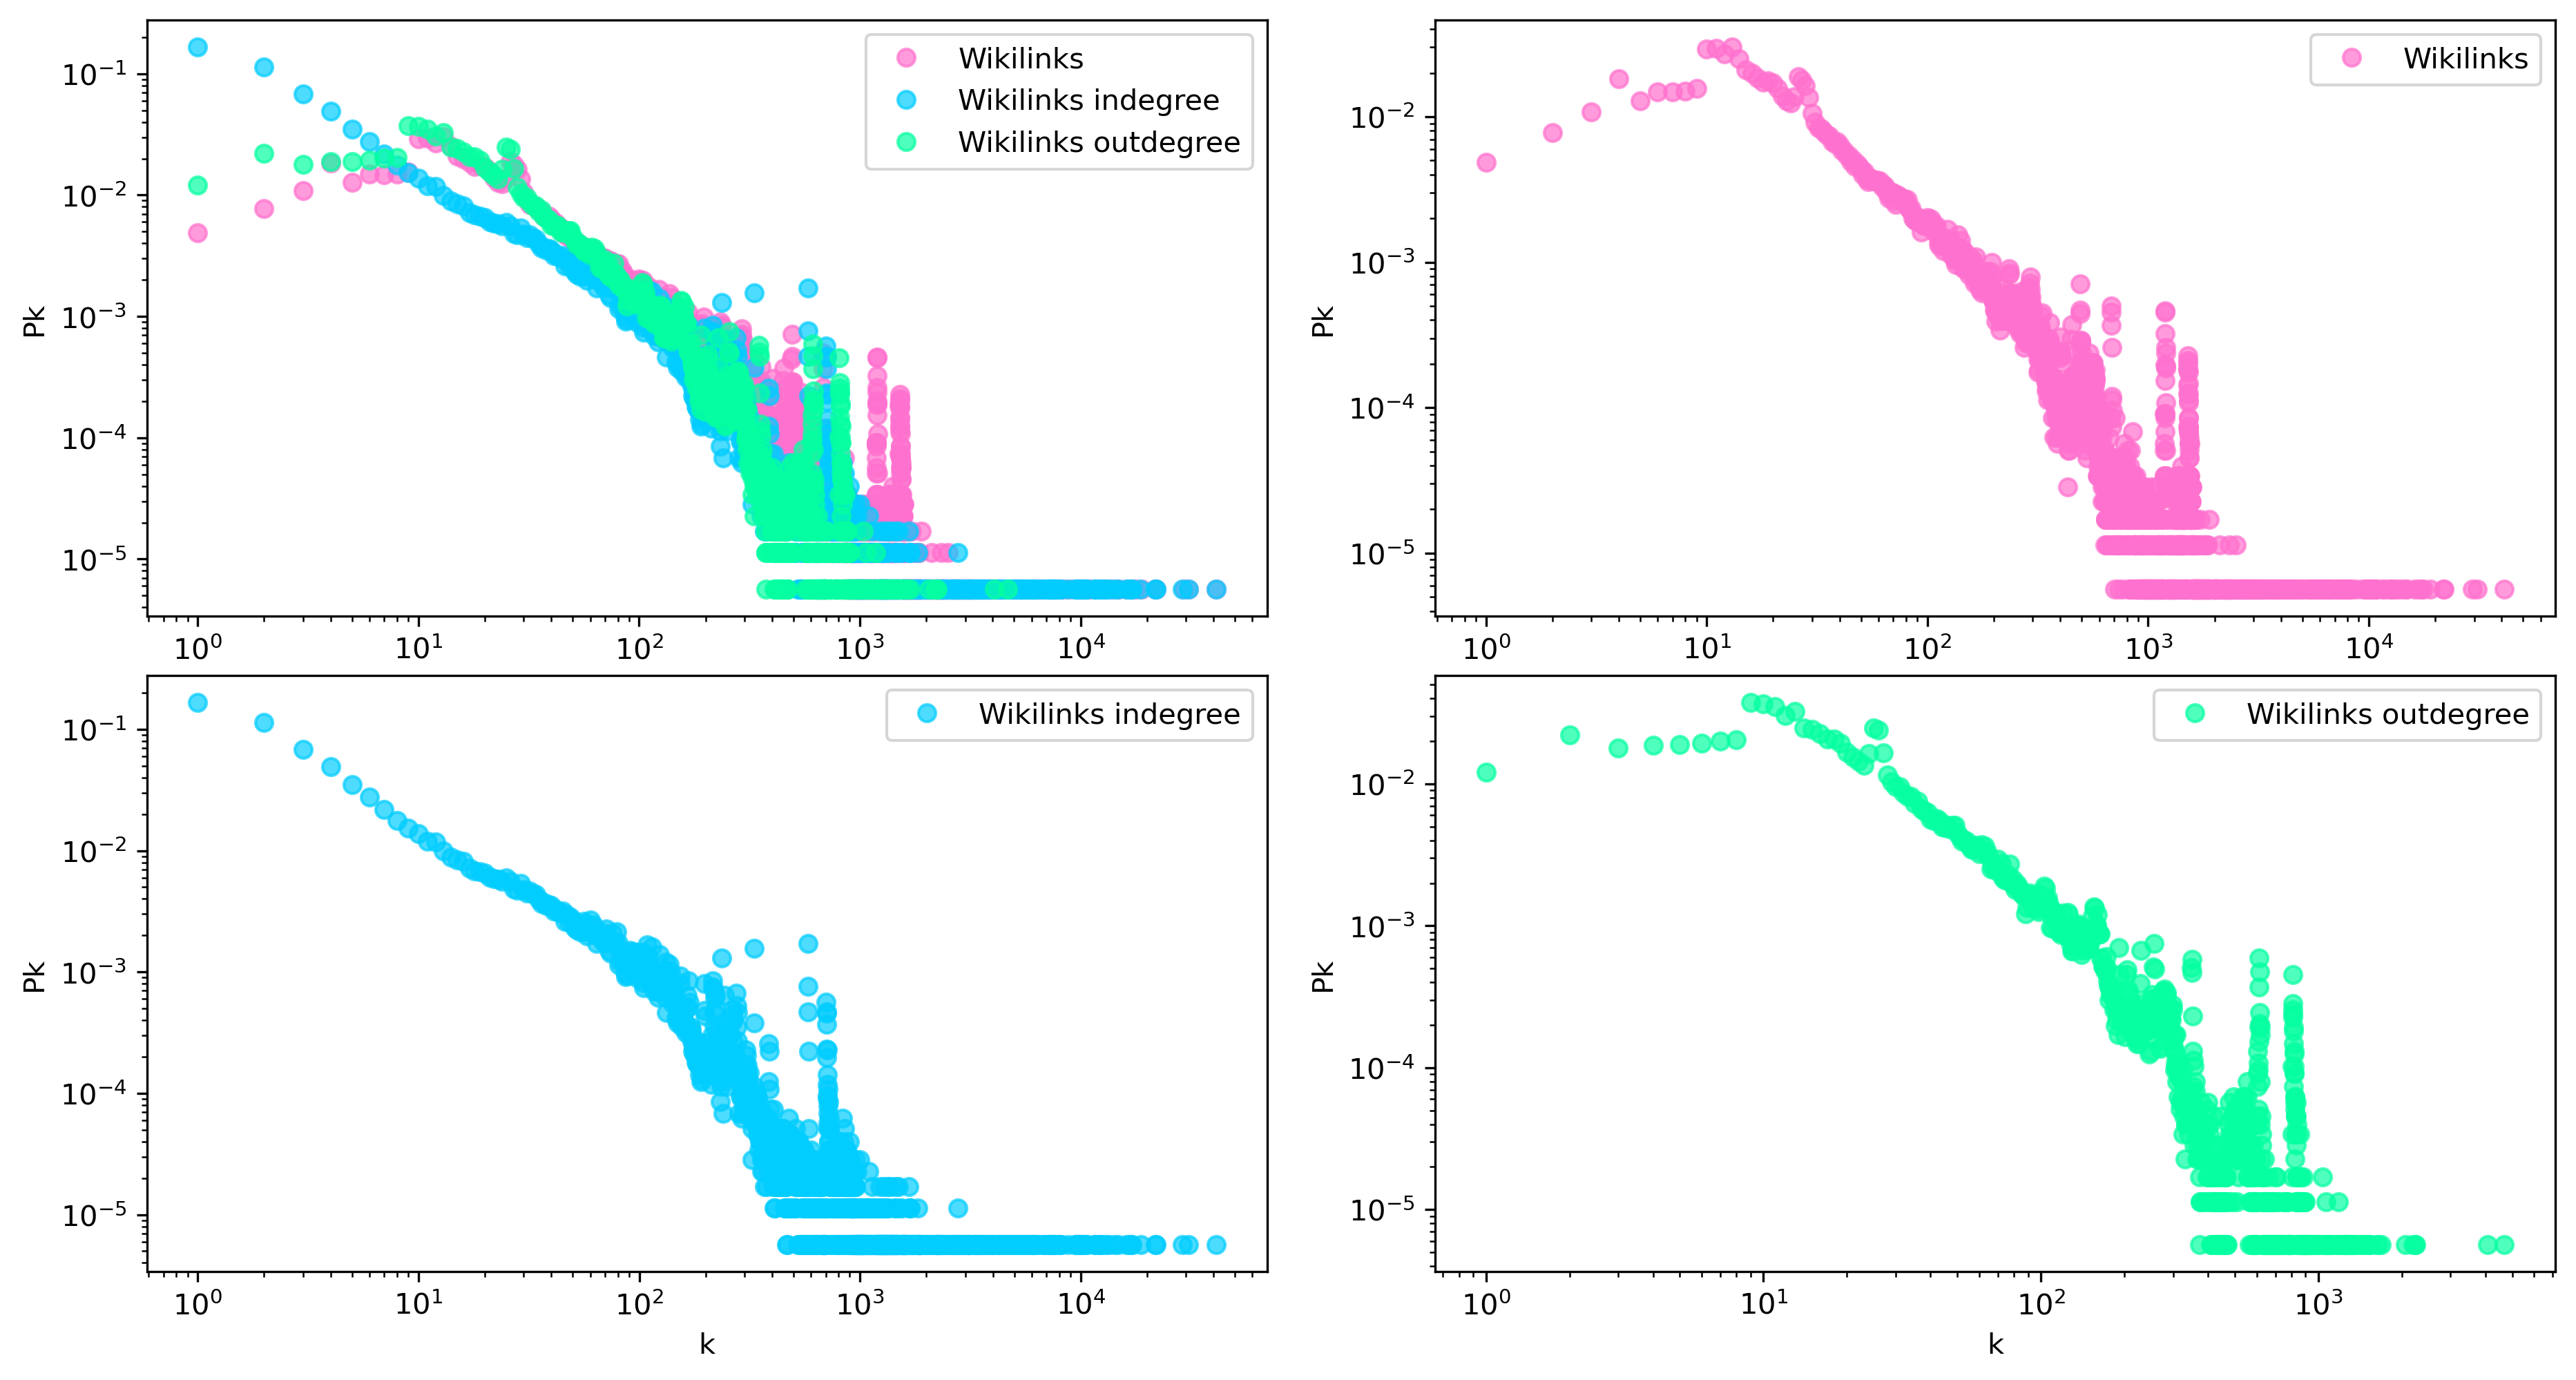

In [223]:
plot_distributions(G, "distribution.png")

In [5]:
G1 = G.copy()

In [11]:
def truncate_network(G, cutoff_views):
    with open("../data/views_map.json", "r") as f:
        views = json.loads(f.read())
    views_set = set(views.keys())

    nodes_to_remove = []
    for node, label in G.nodes(data=True):
        if label["label"] in views_set:
            v = views[label["label"]]

            sum_views_of_page = 0
            for day in v:
                num_views = v[day]
                if num_views != None:
                    sum_views_of_page += num_views
            
            if sum_views_of_page < cutoff_views:
                nodes_to_remove.append(node)
    G.remove_nodes_from(nodes_to_remove)

In [12]:
truncate_network(G1, cutoff_views=5)

In [13]:
G1.number_of_nodes()

103562

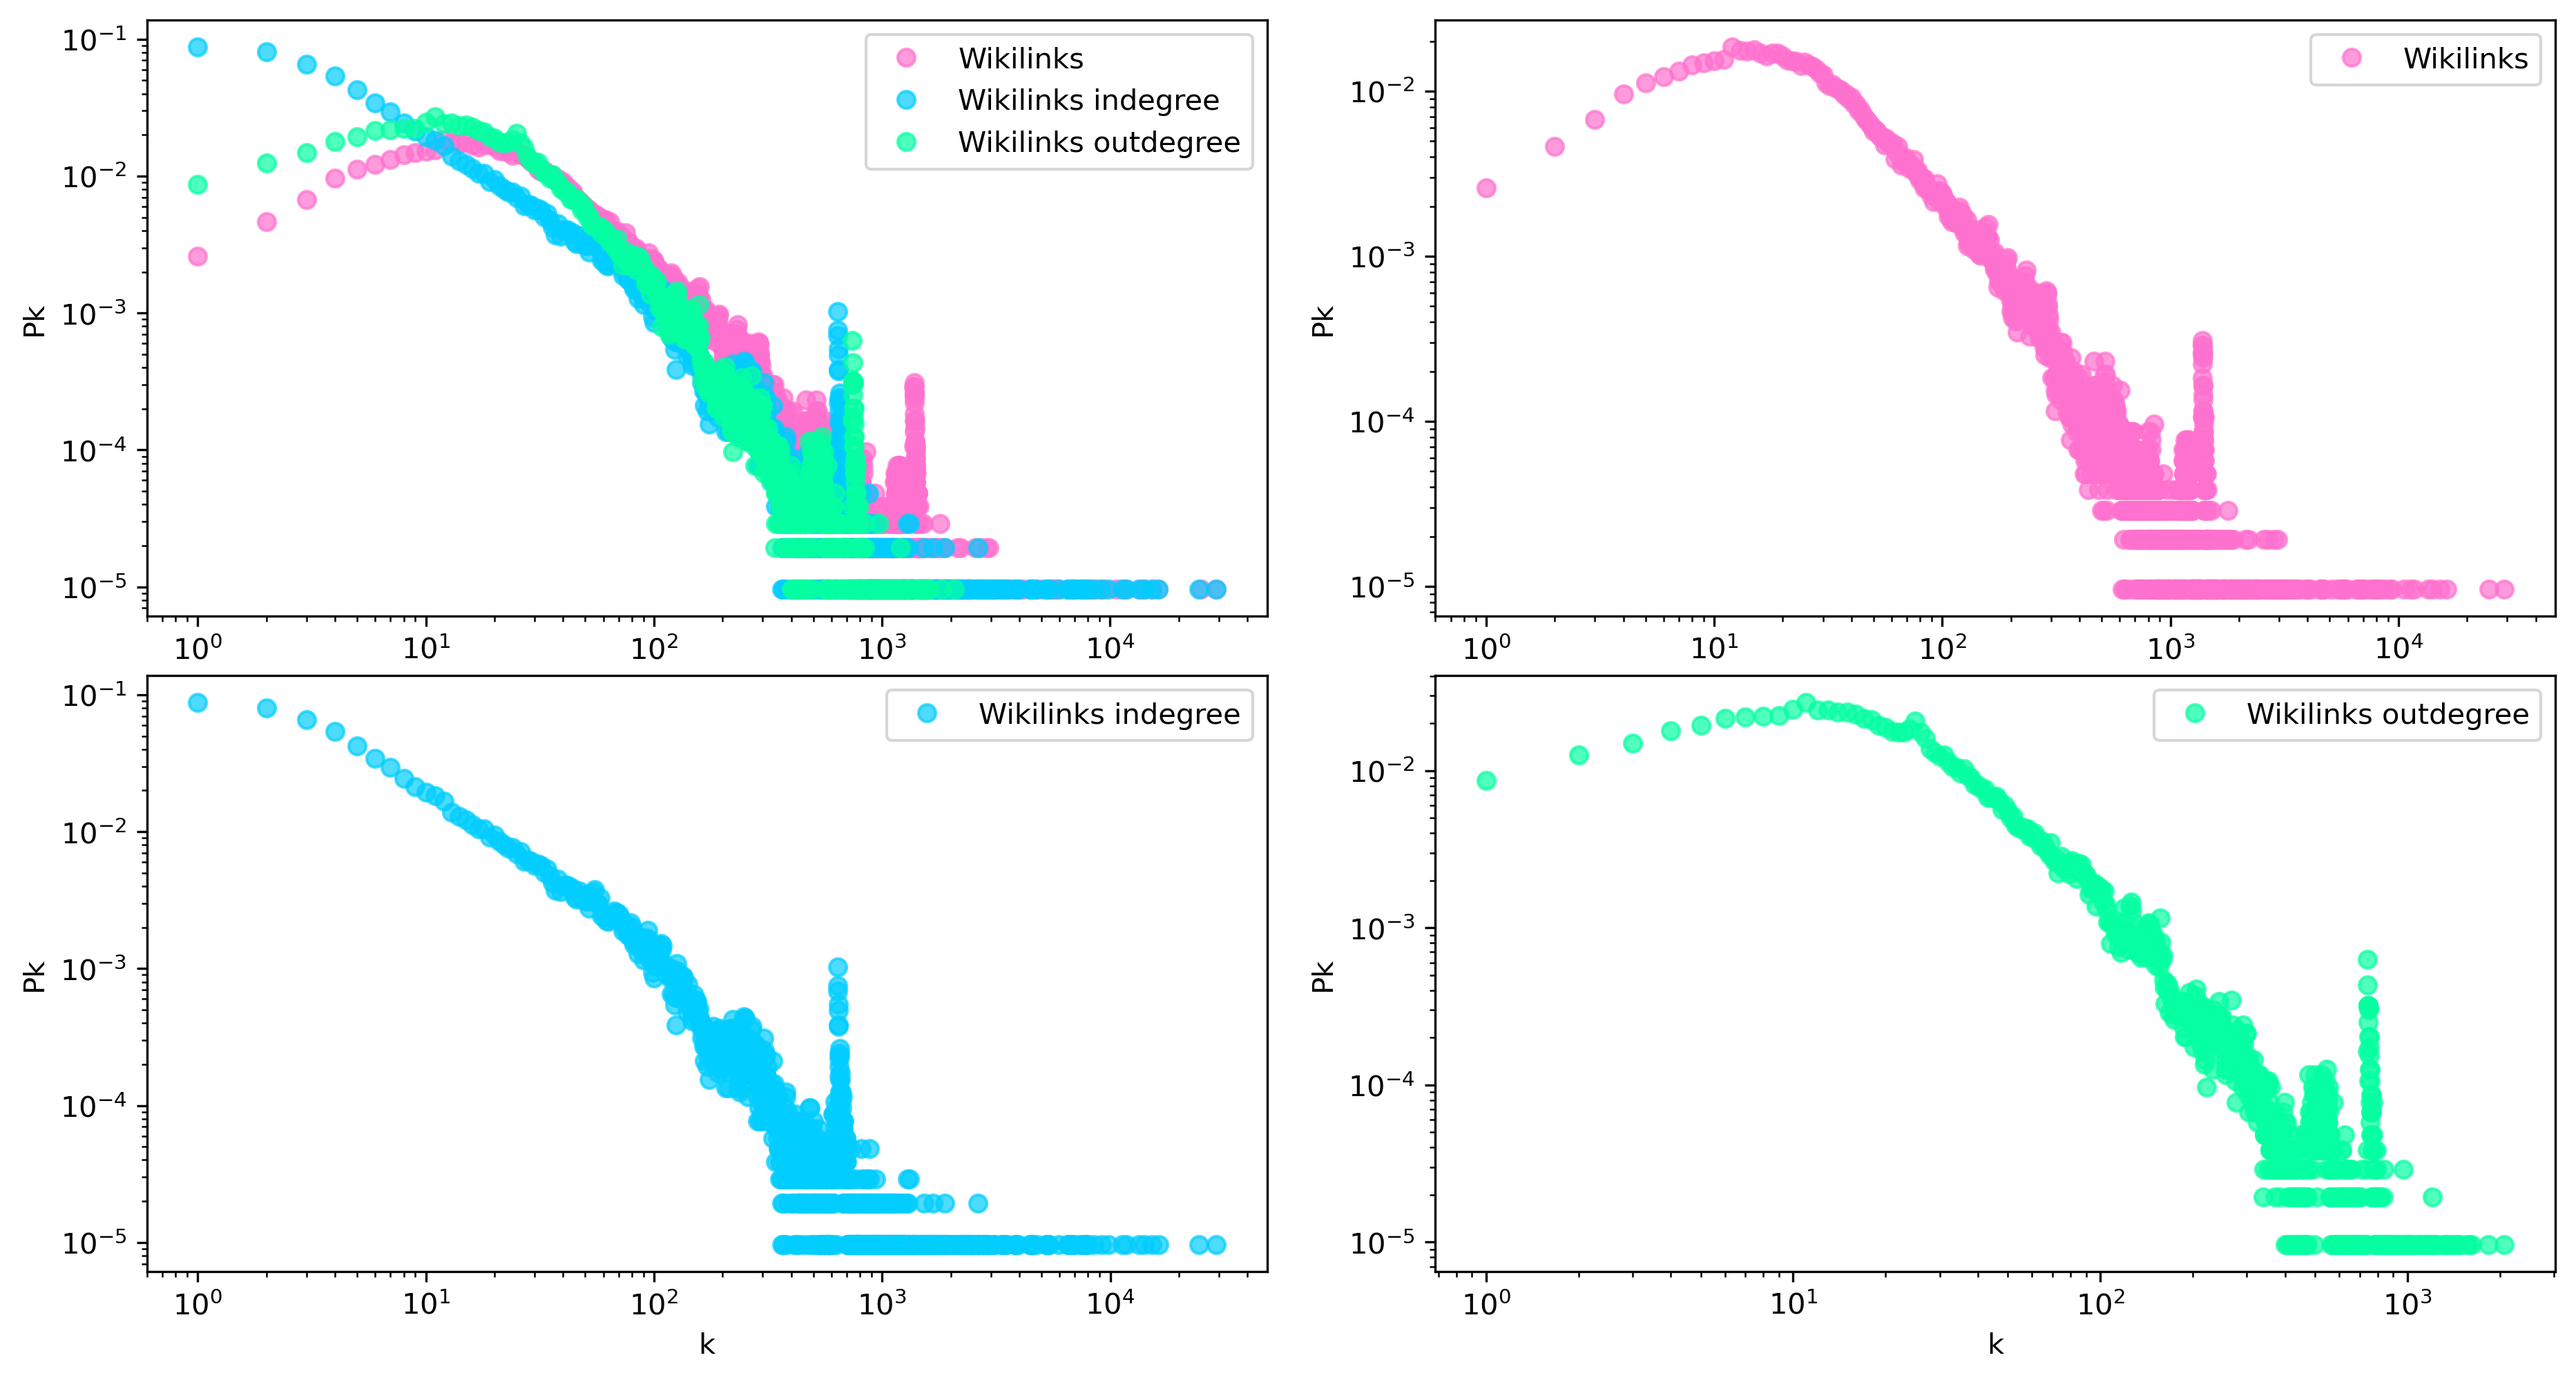

In [236]:
plot_distributions(G1, "distribution-truncated.png")

In [267]:
pr = nx.pagerank(G, alpha=0.9)

In [14]:
EMBEDDING_FILENAME = os.path.join("..", "data", "wikilinks_01.emb")
embeddings_truncated = np.genfromtxt(EMBEDDING_FILENAME, delimiter=',')

In [269]:
sizes = np.array(list(pr.values()))
colors = np.array(list(pr.values()))
h = 50
l = 0
sizes = (sizes - min(sizes)) / (max(sizes) - min(sizes)) * (h - l) + l
sizes = sizes**2

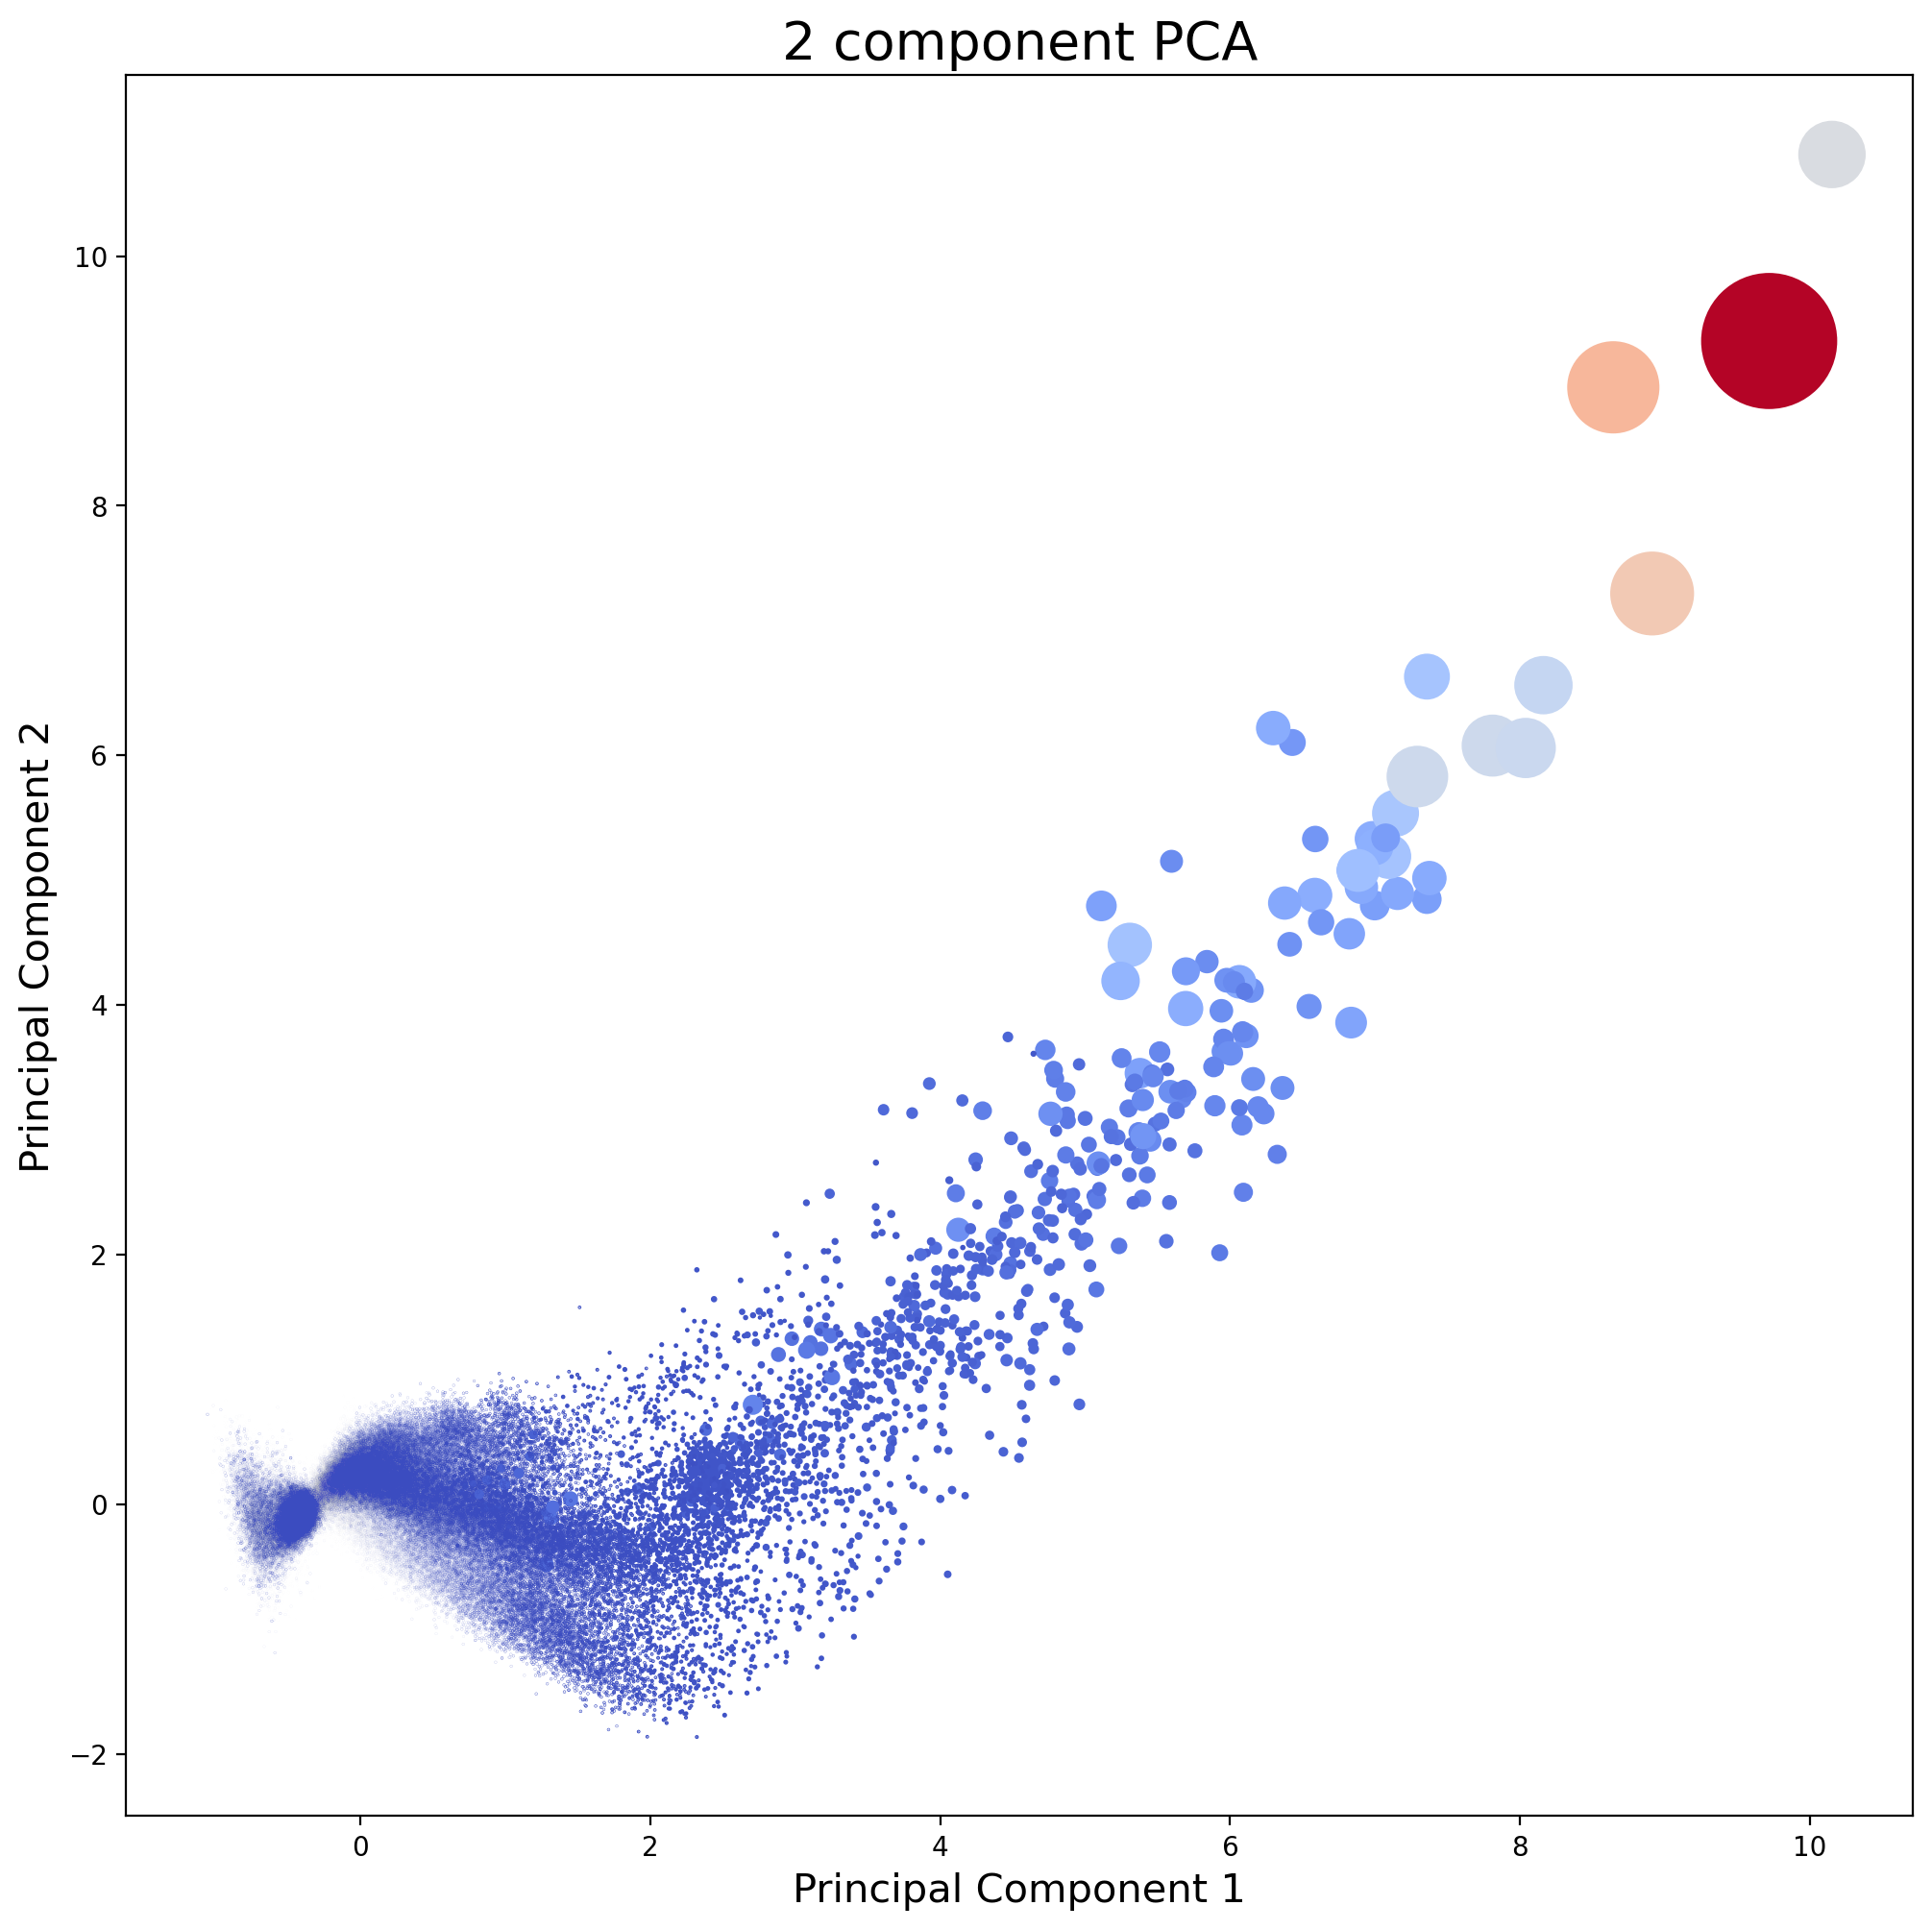

In [270]:
plot_pca_2d(embeddings_truncated, sizes, colors, "pca-truncated.png")

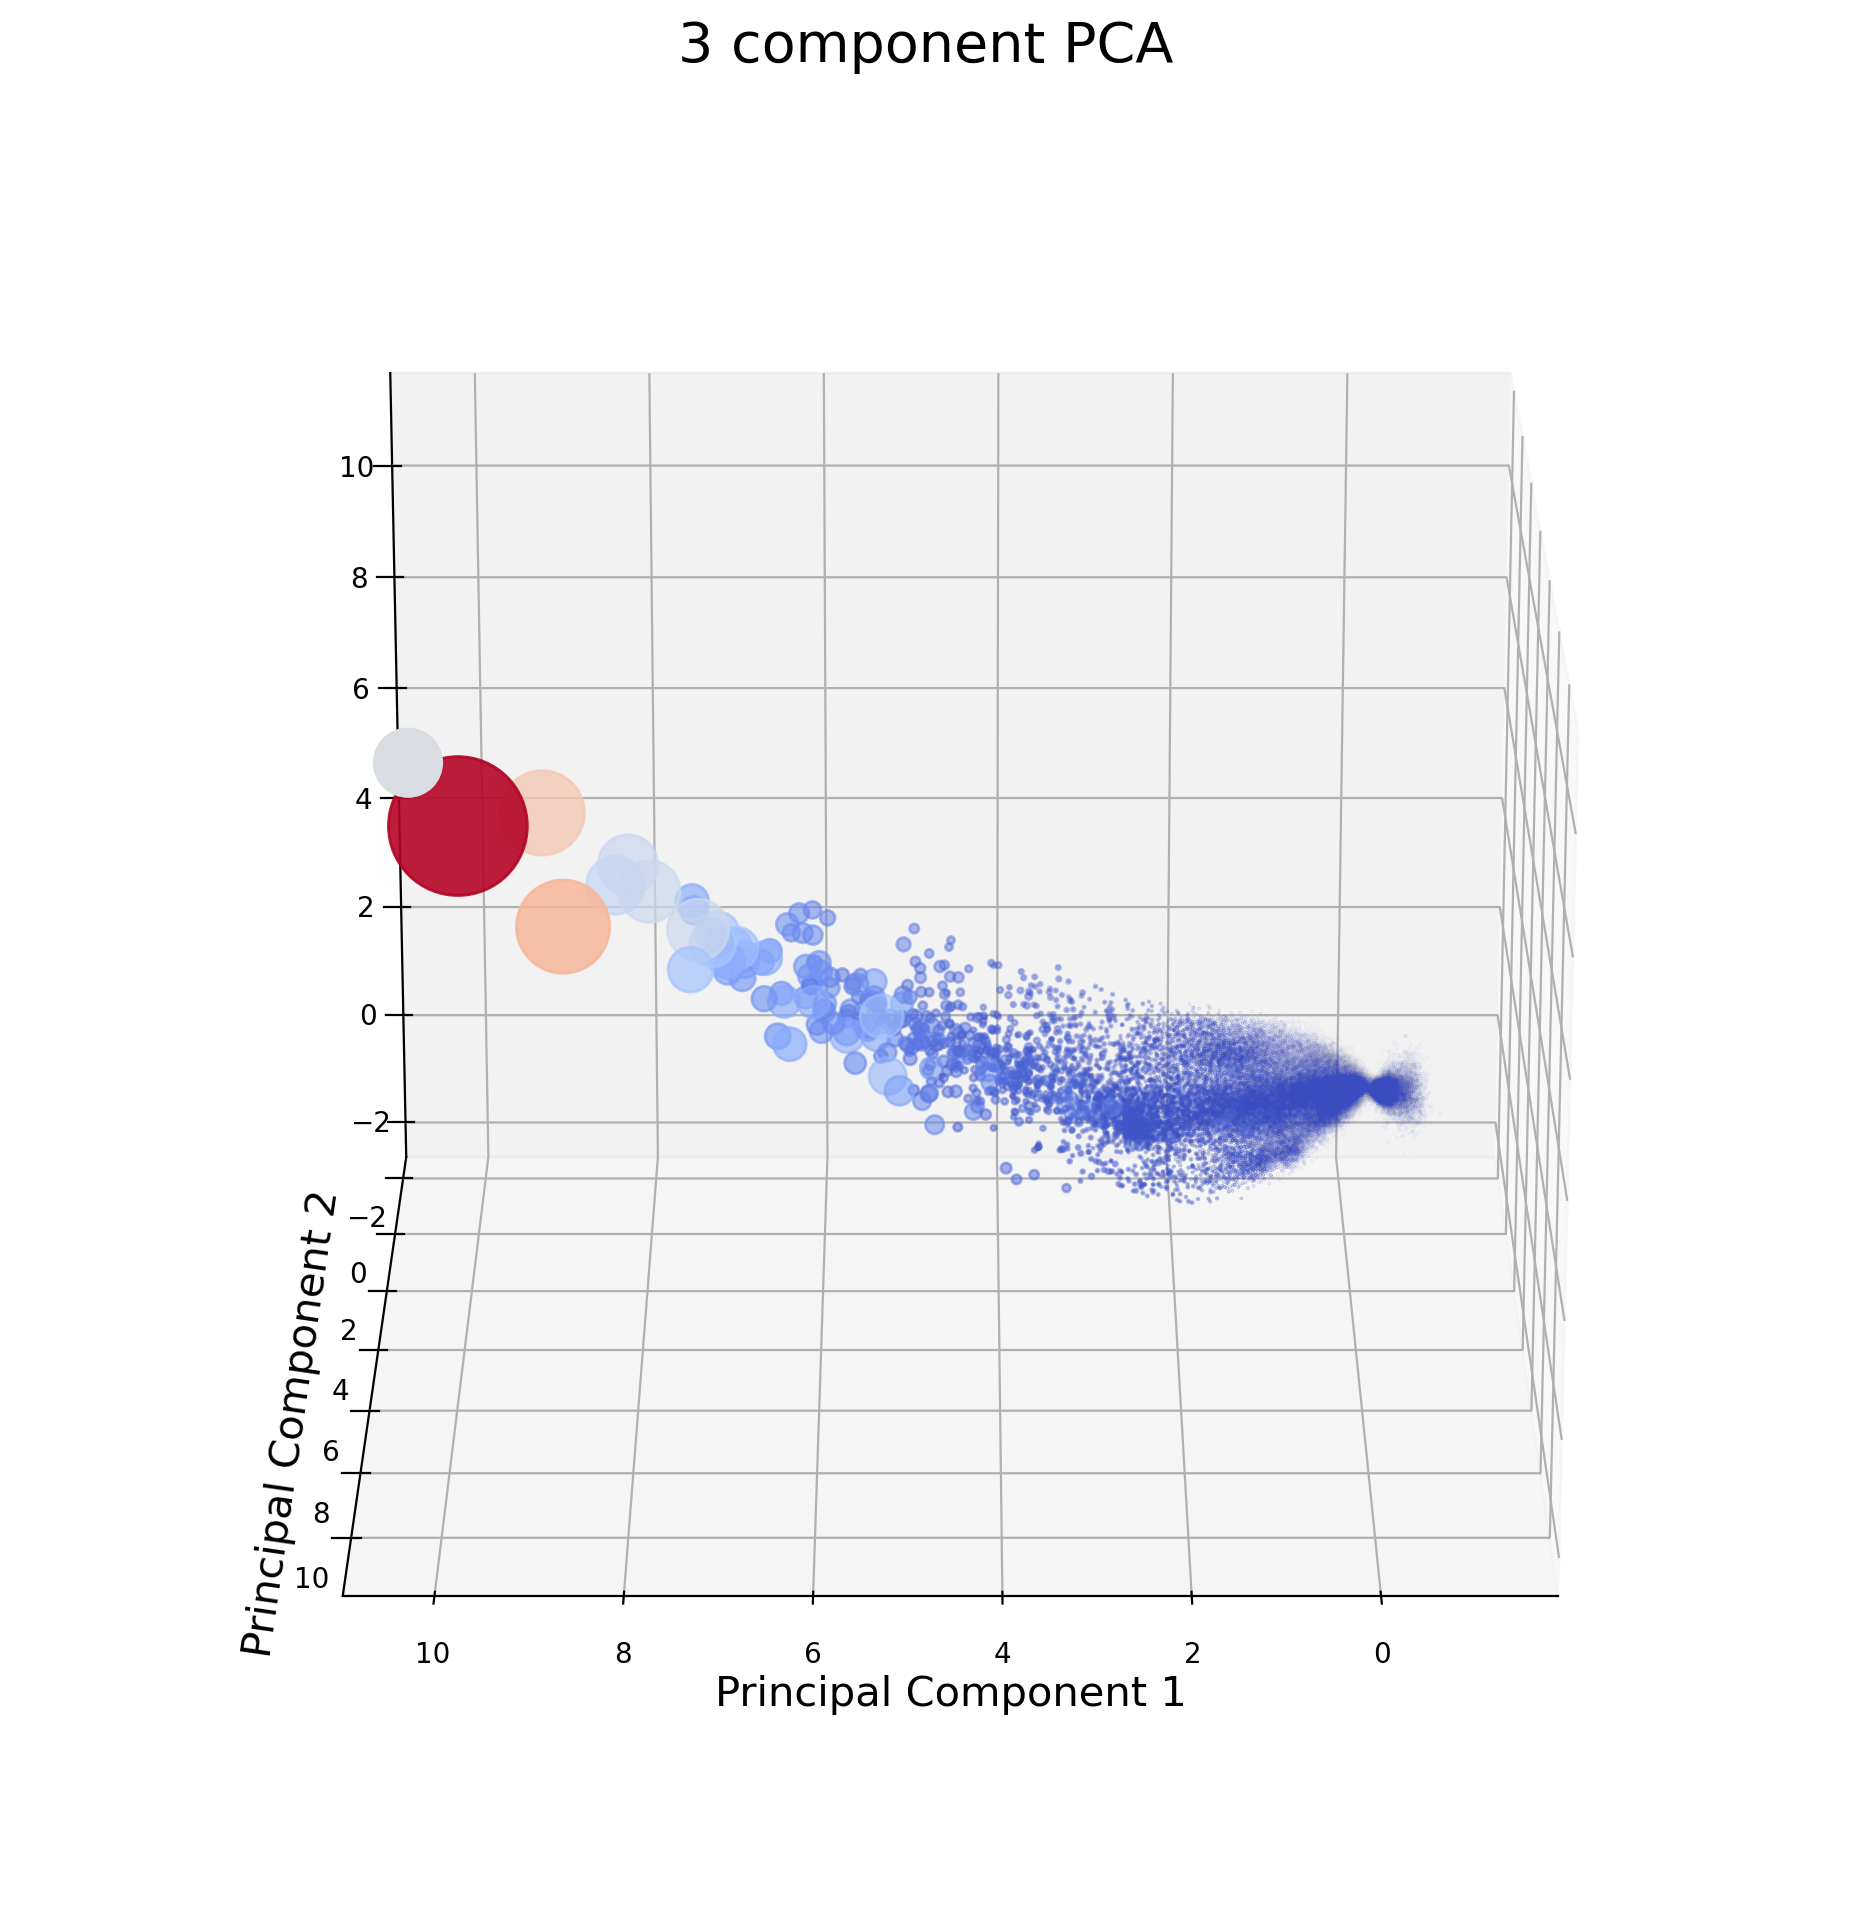

In [271]:
plot_pca_3d(embeddings_truncated, sizes, colors, "pca3d-truncated.png")

In [301]:
top_pr = np.argsort(np.array(list(pr.values())))[::-1][:10]

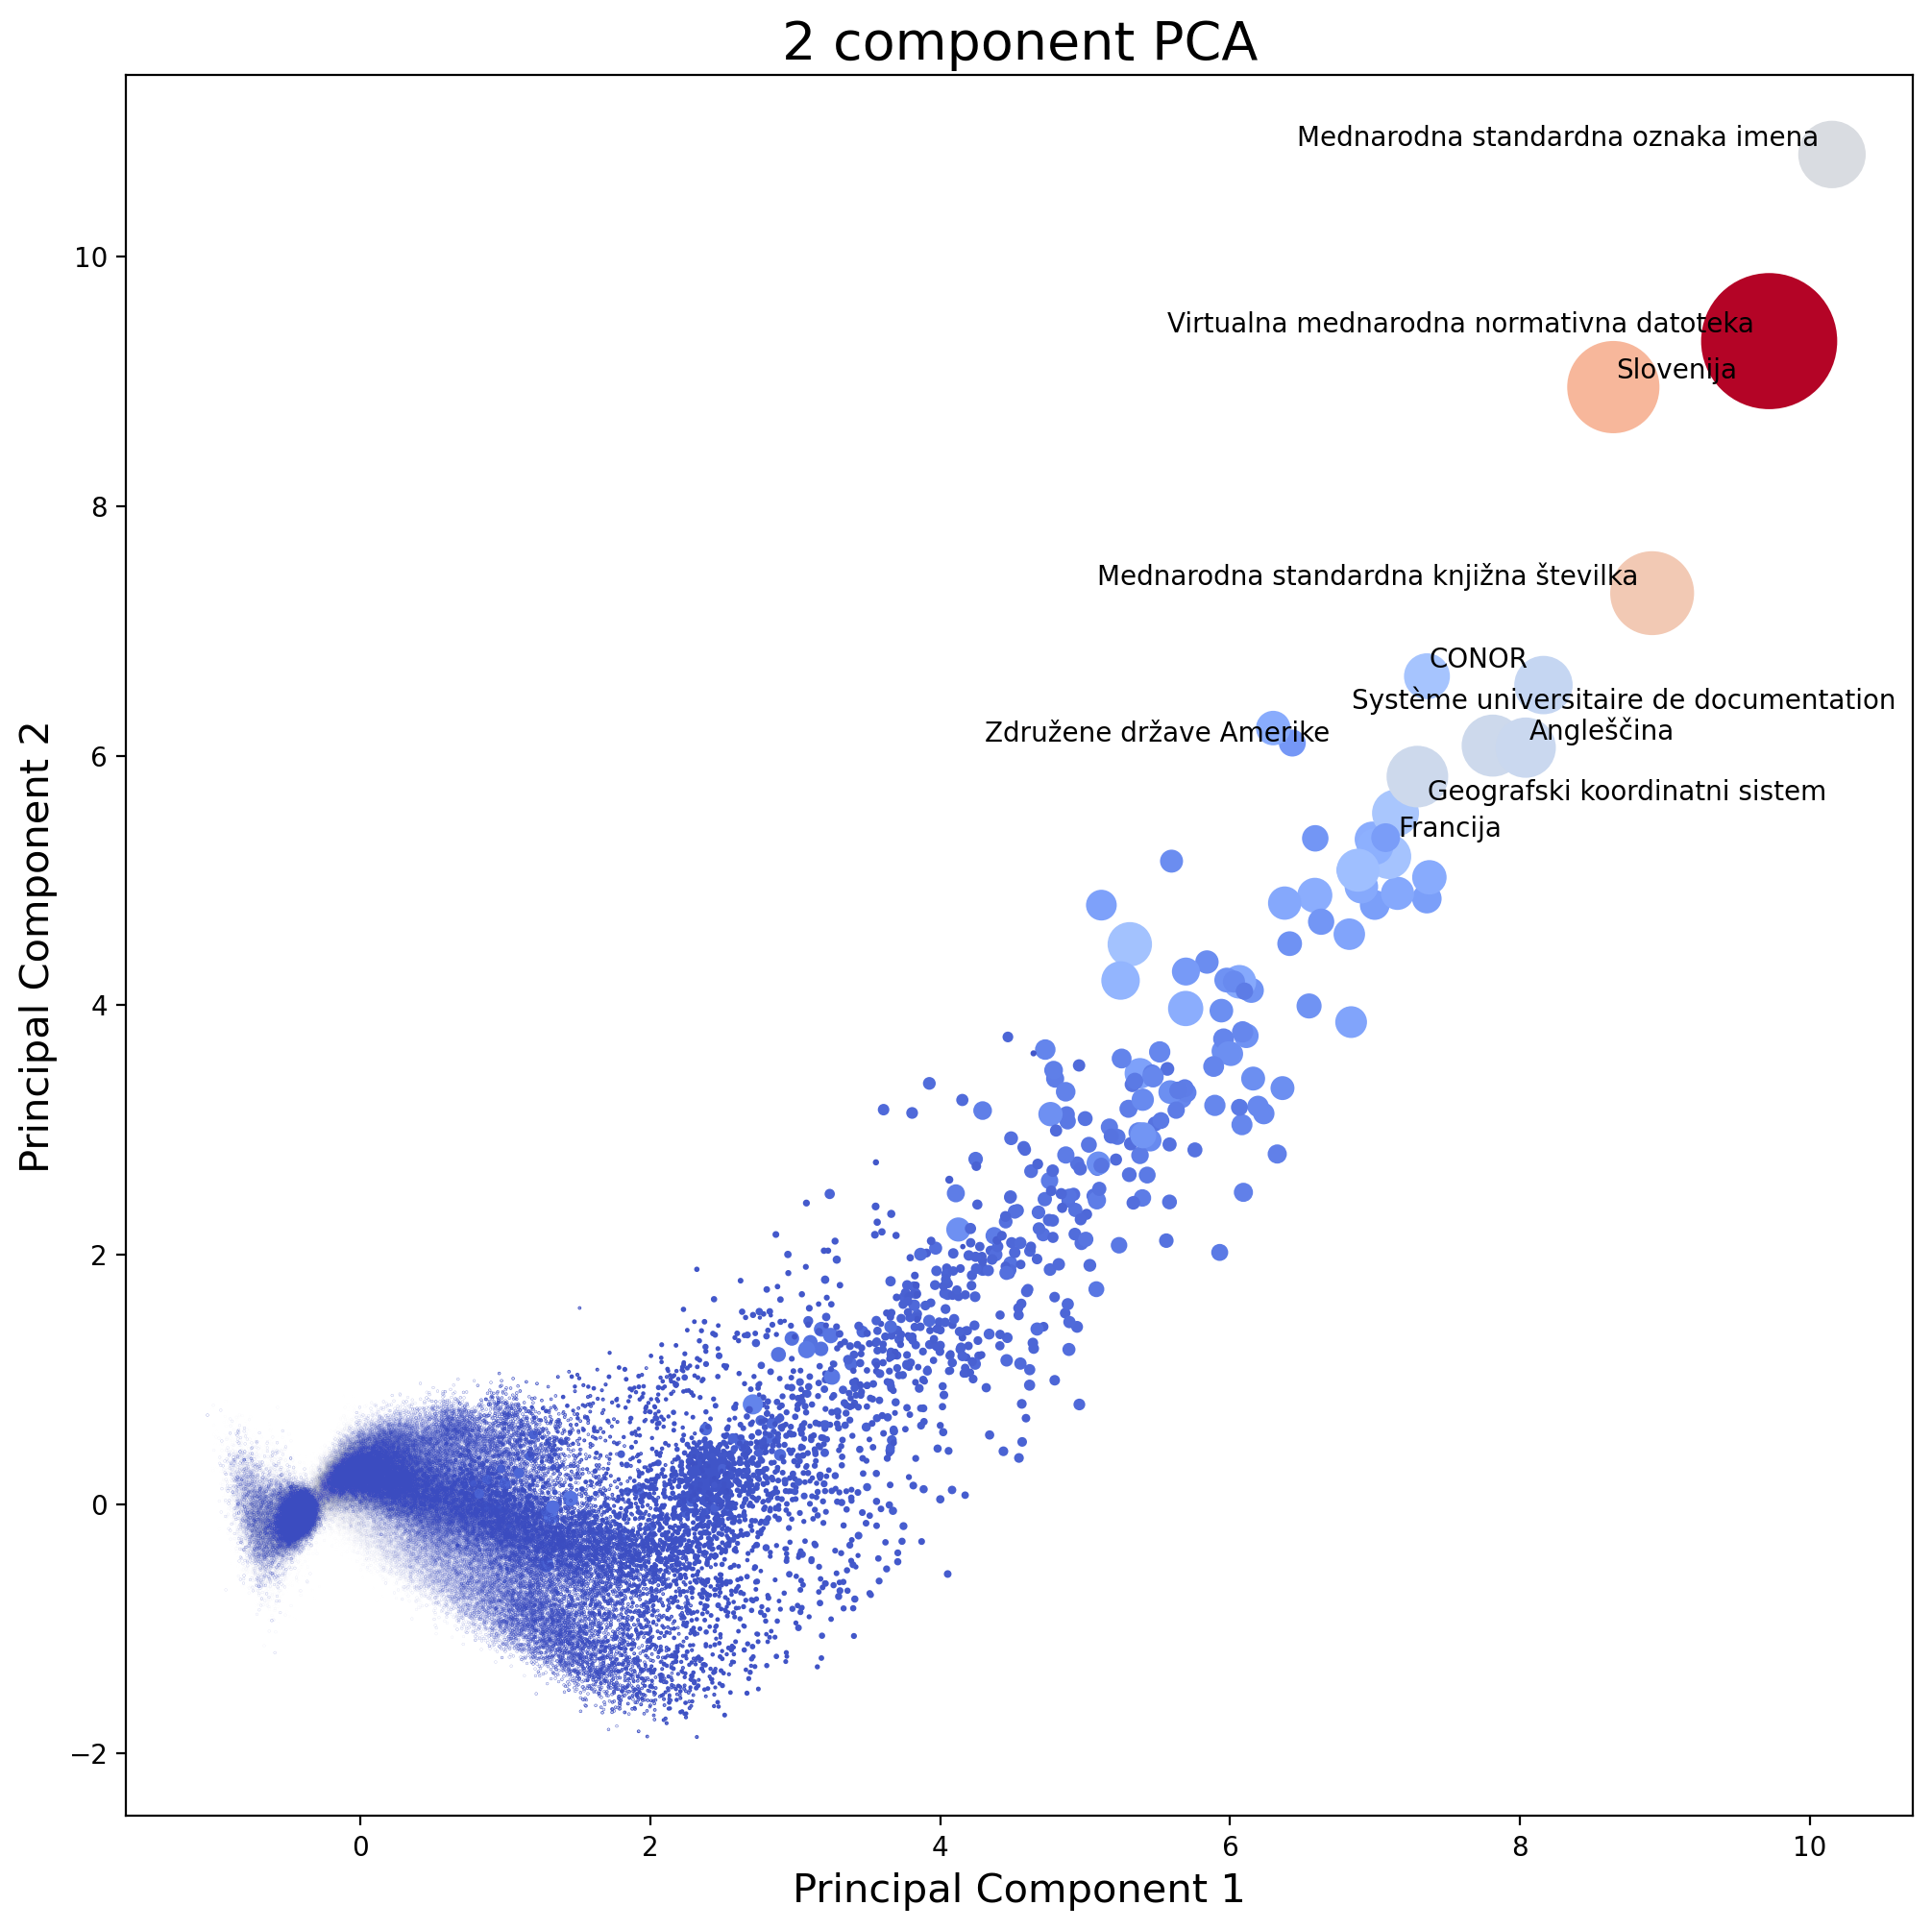

In [314]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings_truncated)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (12,12), facecolor="white", dpi=200)
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], s=sizes, c=colors, cmap=plt.cm.coolwarm)

texts = []
for i in top_pr:
    x = principalDf['principal component 1'][i]
    y = principalDf['principal component 2'][i]
    texts.append(plt.text(x, y, s=id_to_title_map[G1.nodes(data=True)[i]["label"]]))

adjust_text(texts)

plt.savefig("../img/pca-truncated-with-text.png", bbox_inches="tight", dpi=200)
plt.show()

In [8]:
with open("../data/centralities/CC.json", "r") as f:
    cc = json.loads(f.read())

In [21]:
sizes = np.array(list(cc.values()))
colors = np.array(list(cc.values()))
h = 50
l = 0
sizes = (sizes - min(sizes)) / (max(sizes) - min(sizes)) * (h - l) + l

In [22]:
top_cc = np.argsort(np.array(list(cc.values())))[::-1][:10]

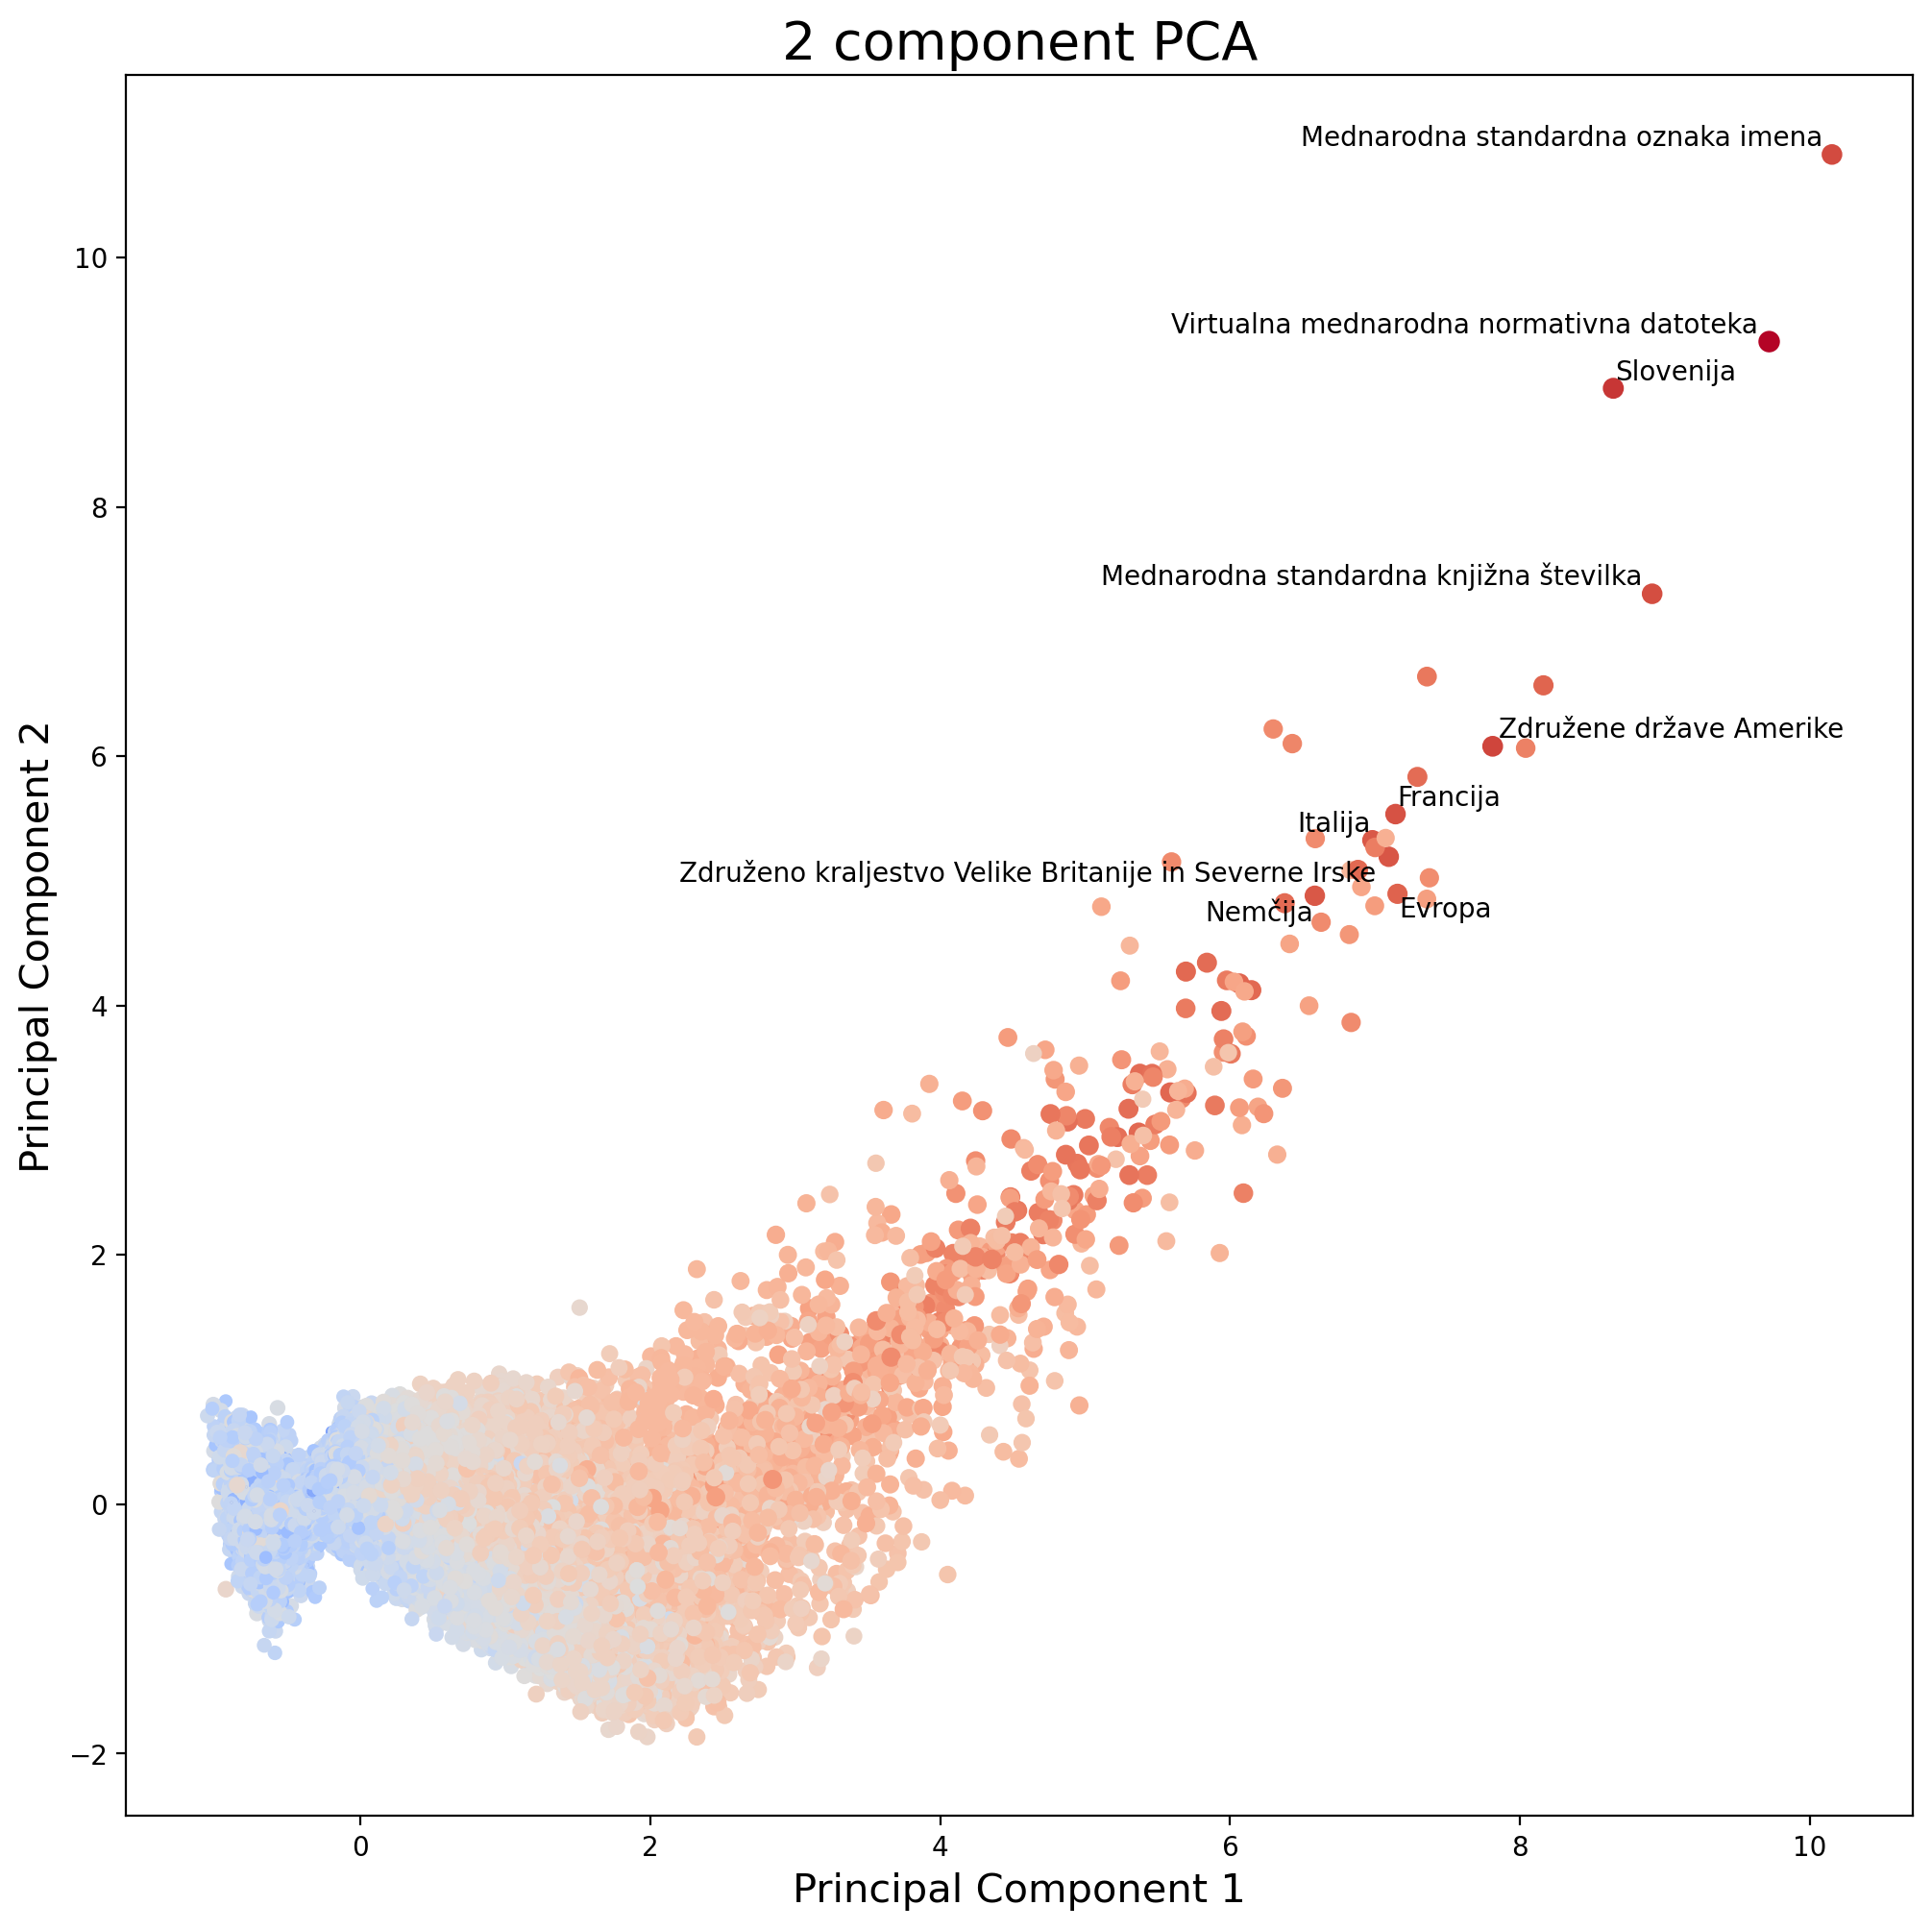

In [23]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeddings_truncated)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (12,12), facecolor="white", dpi=200)
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], s=sizes, c=colors, cmap=plt.cm.coolwarm)

texts = []
for i in top_cc:
    x = principalDf['principal component 1'][i]
    y = principalDf['principal component 2'][i]
    texts.append(plt.text(x, y, s=id_to_title_map[G1.nodes(data=True)[i]["label"]]))

adjust_text(texts)

plt.savefig("../img/pca-truncated-with-text-CC.png", bbox_inches="tight", dpi=200)
plt.show()

In [169]:
def number_of_views(G):
    with open("../data/views_map.json", "r") as f:
        views = json.loads(f.read())
    views_set = set(views.keys())

    num_views_aggregated = dict()
    for i in range(4):
        num_views_aggregated[i] = defaultdict(int)

    for node, label in G.nodes(data=True):
        if label["label"] in views_set:
            v = views[label["label"]]

            for idx, day in enumerate(v):
                num_views = v[day]
                if num_views != None:
                    num_views_aggregated[idx // 15][node] += num_views
                else:
                    num_views_aggregated[idx // 15][node] += 0
        else:
            for i in range(4):
                num_views_aggregated[i][node] = 0

    return num_views_aggregated

In [170]:
num_views = number_of_views(G)

In [171]:
def plot_views(embeddings, num_views, filename):

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(embeddings)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    fig = plt.figure(figsize = (12,12), facecolor="white", dpi=200)
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    sizes = np.array(list(num_views.values()))
    h = 40
    l = 0
    sizes = (sizes - min(sizes)) / (max(sizes) - min(sizes)) * (h - l) + l
    sizes = sizes**2
    colors = sizes

    ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], s=sizes, c=colors, cmap=plt.cm.coolwarm)

    top = dict(sorted(num_views.items(), key=lambda item: item[1], reverse=True))

    texts = []
    count = 0
    for i, score in top.items():
        if i in principalDf['principal component 1'] and i in principalDf['principal component 2']:
            x = principalDf['principal component 1'][i]
            y = principalDf['principal component 2'][i]
            texts.append(plt.text(x, y, s=id_to_title_map[G1.nodes(data=True)[i]["label"]]))

        count += 1
        if count == 10:
            break

    adjust_text(texts)

    plt.savefig("../img/" + filename, bbox_inches="tight", dpi=200)
    plt.show()

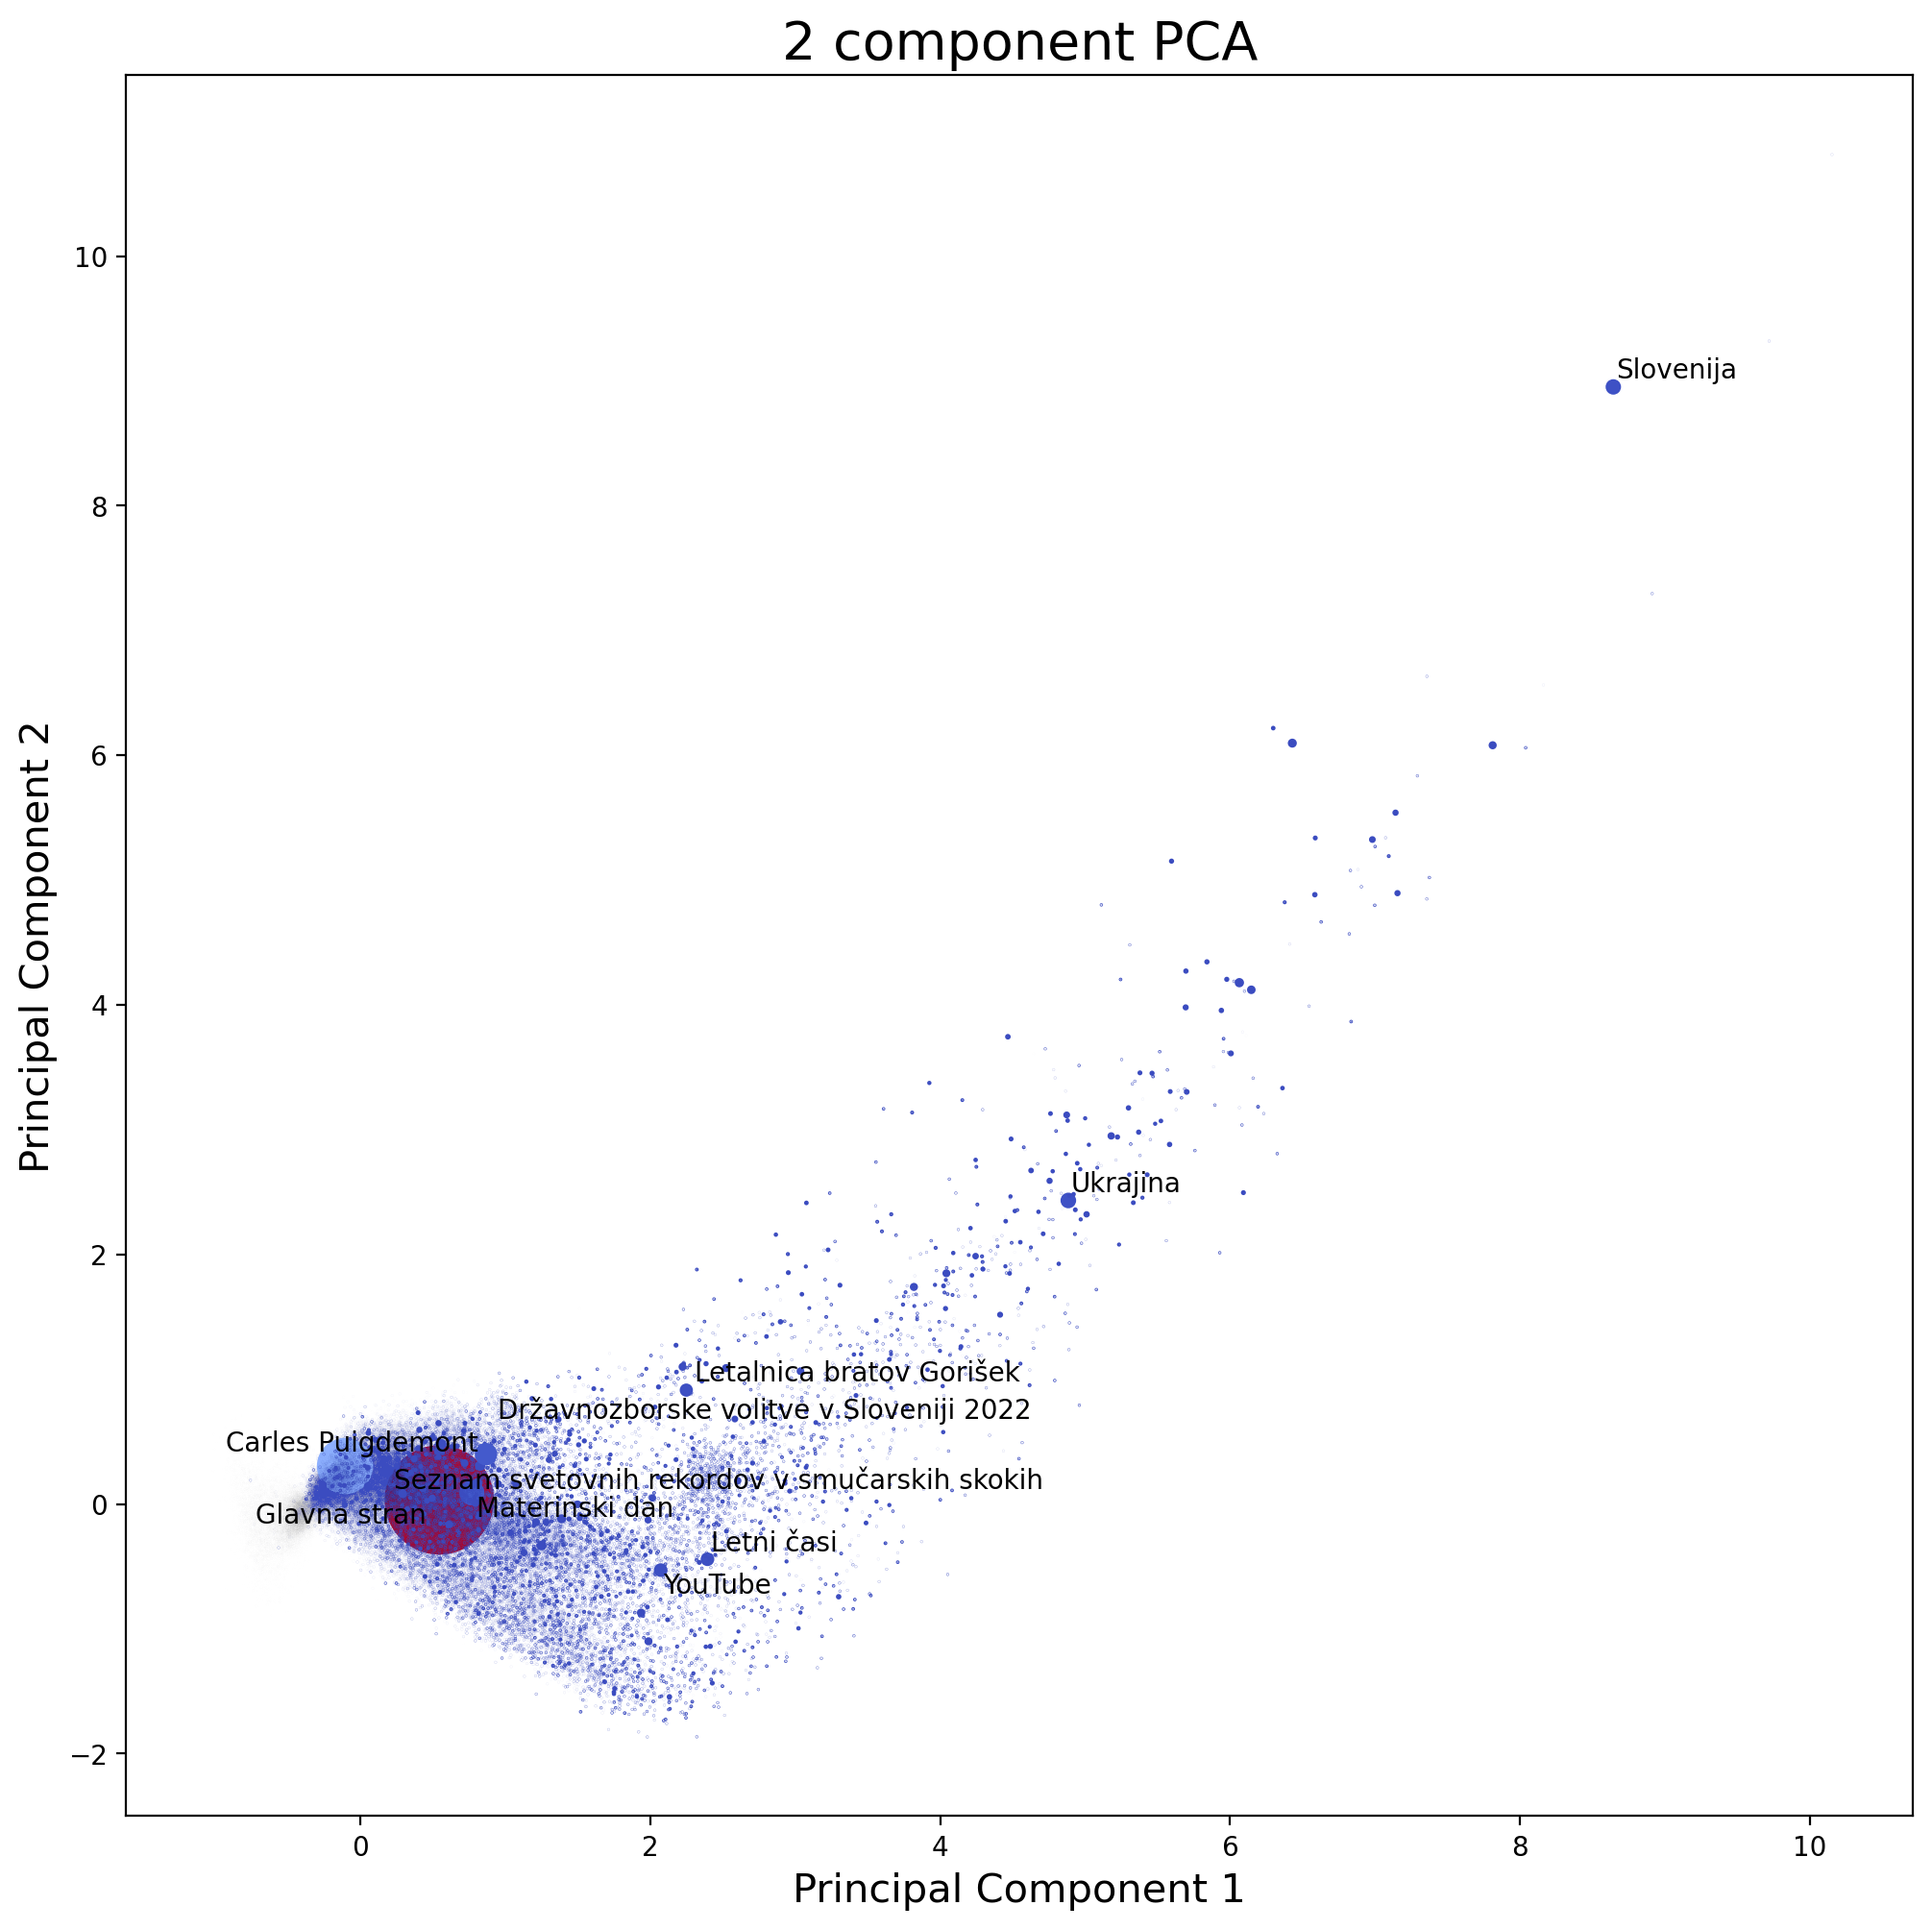

In [160]:
plot_views(embeddings_truncated, num_views[0], "views_01.png")

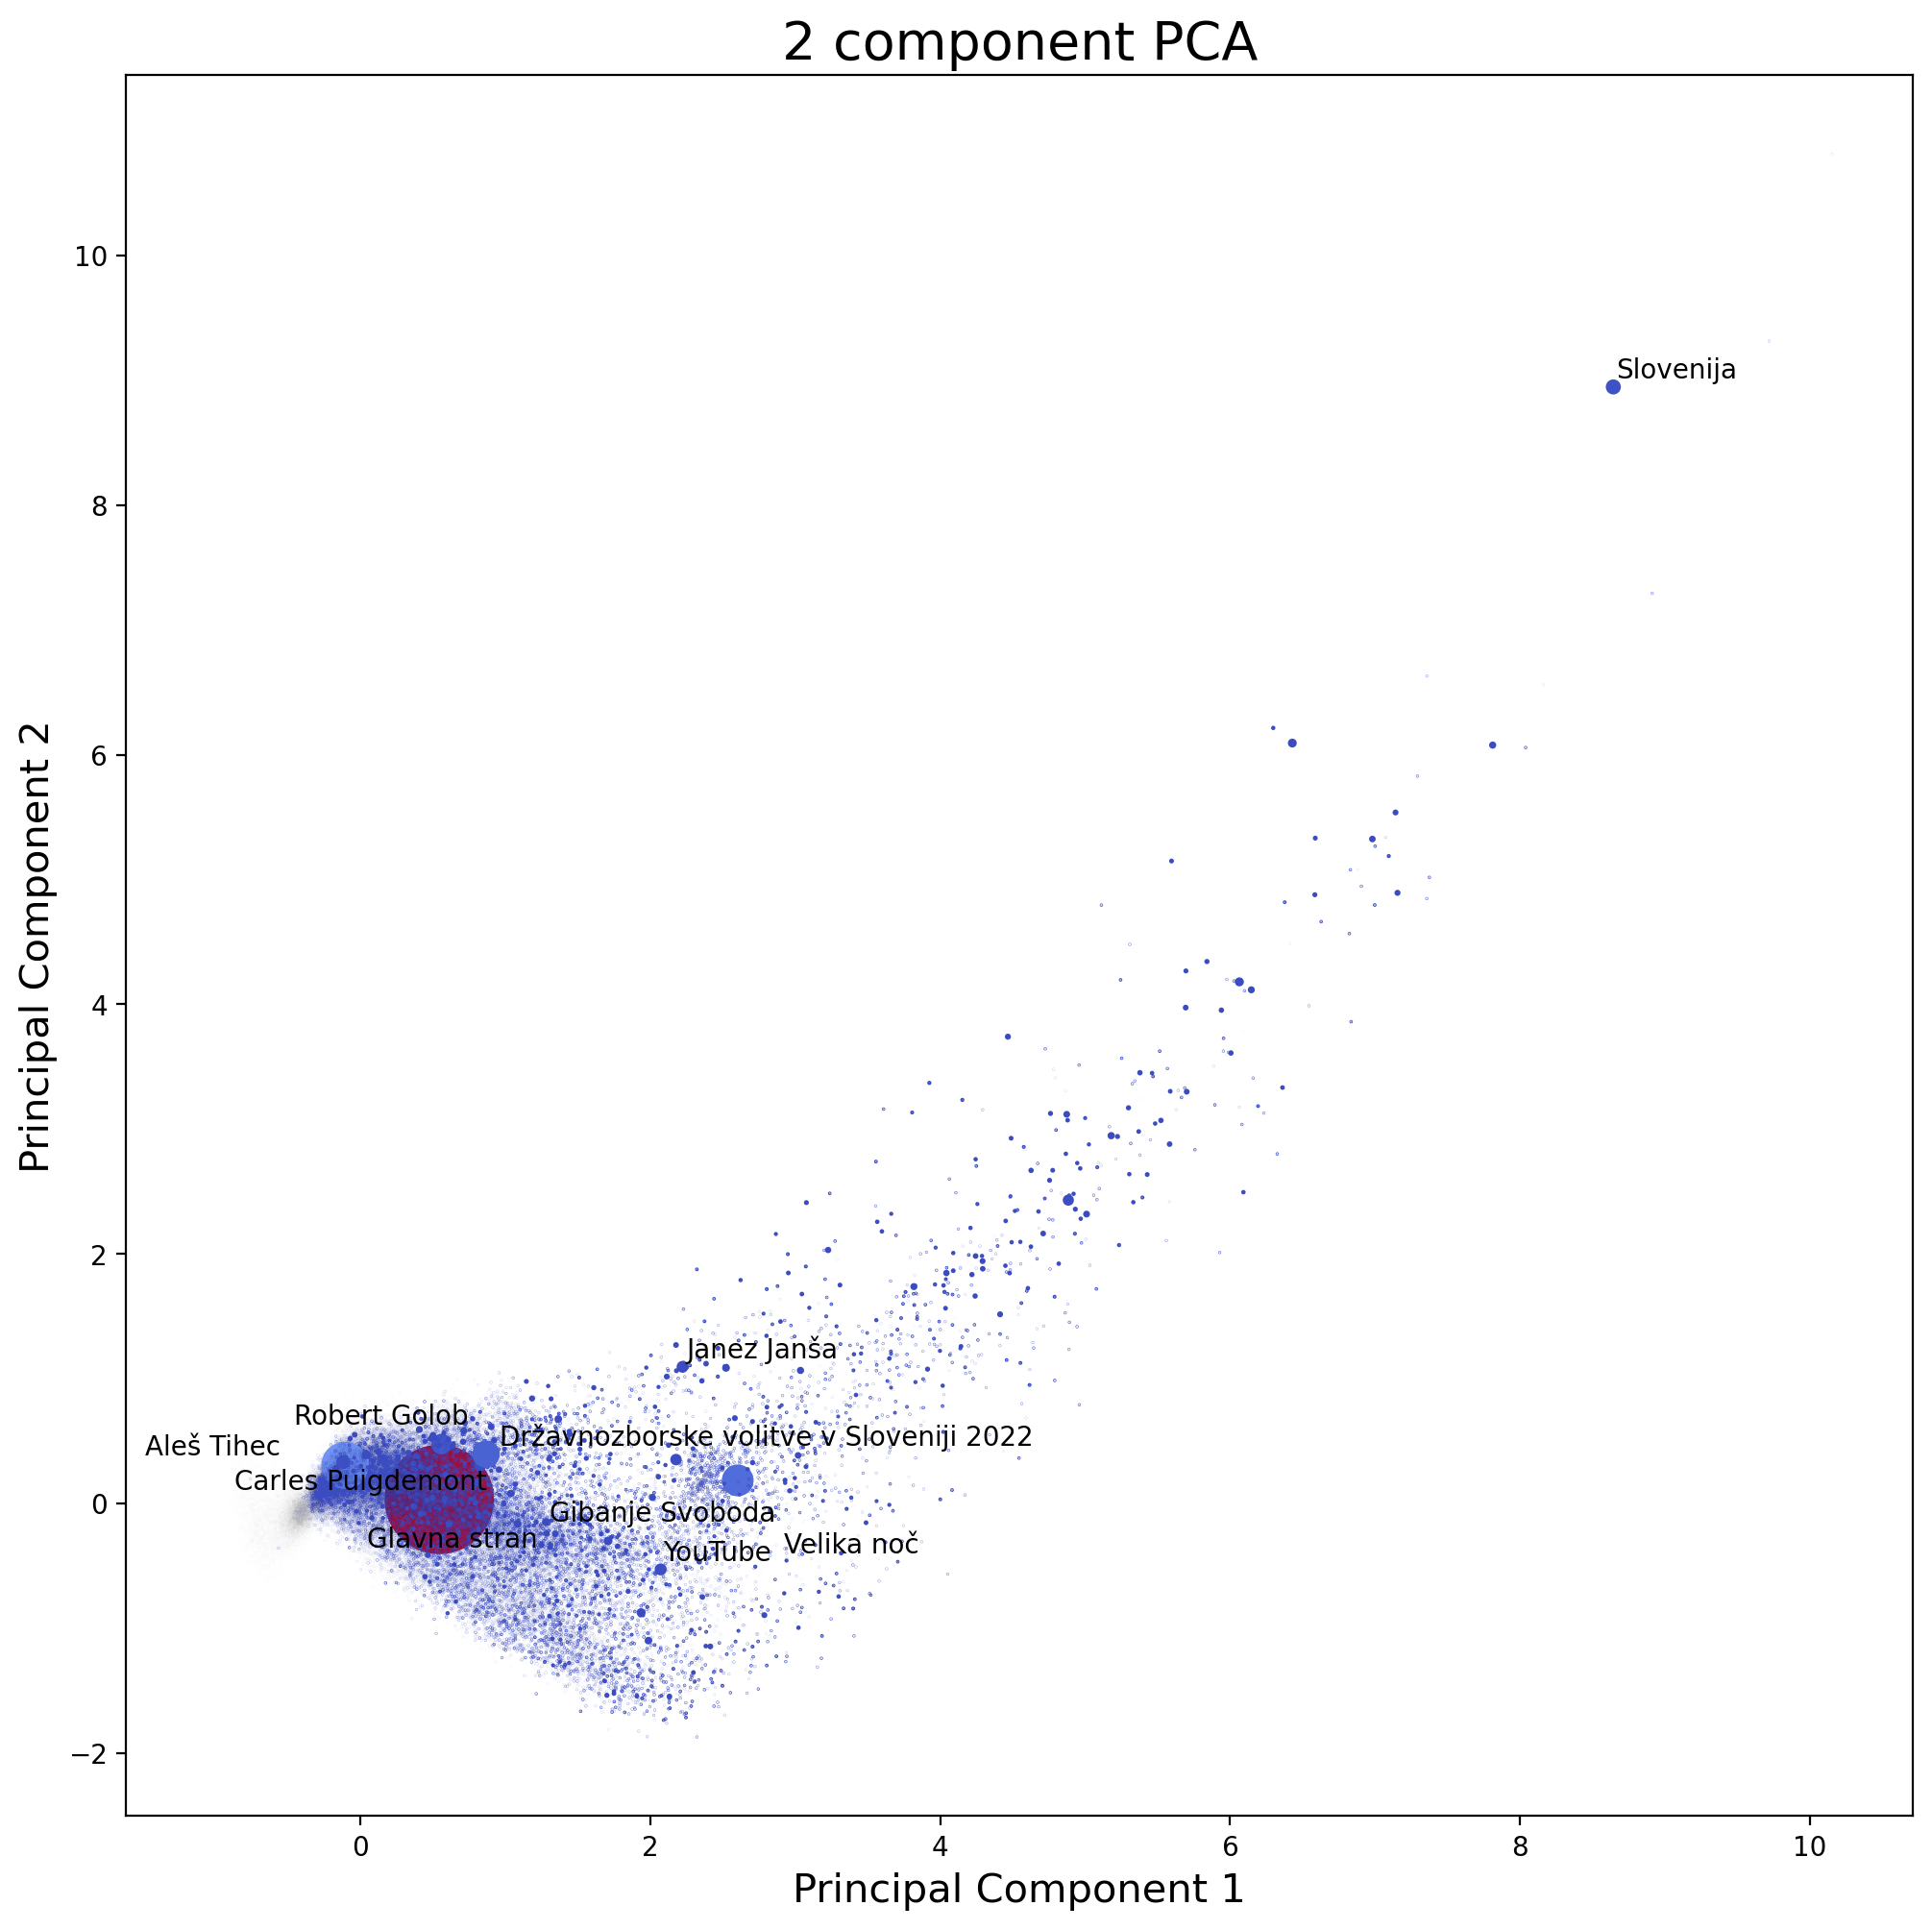

In [161]:
plot_views(embeddings_truncated, num_views[1], "views_02.png")

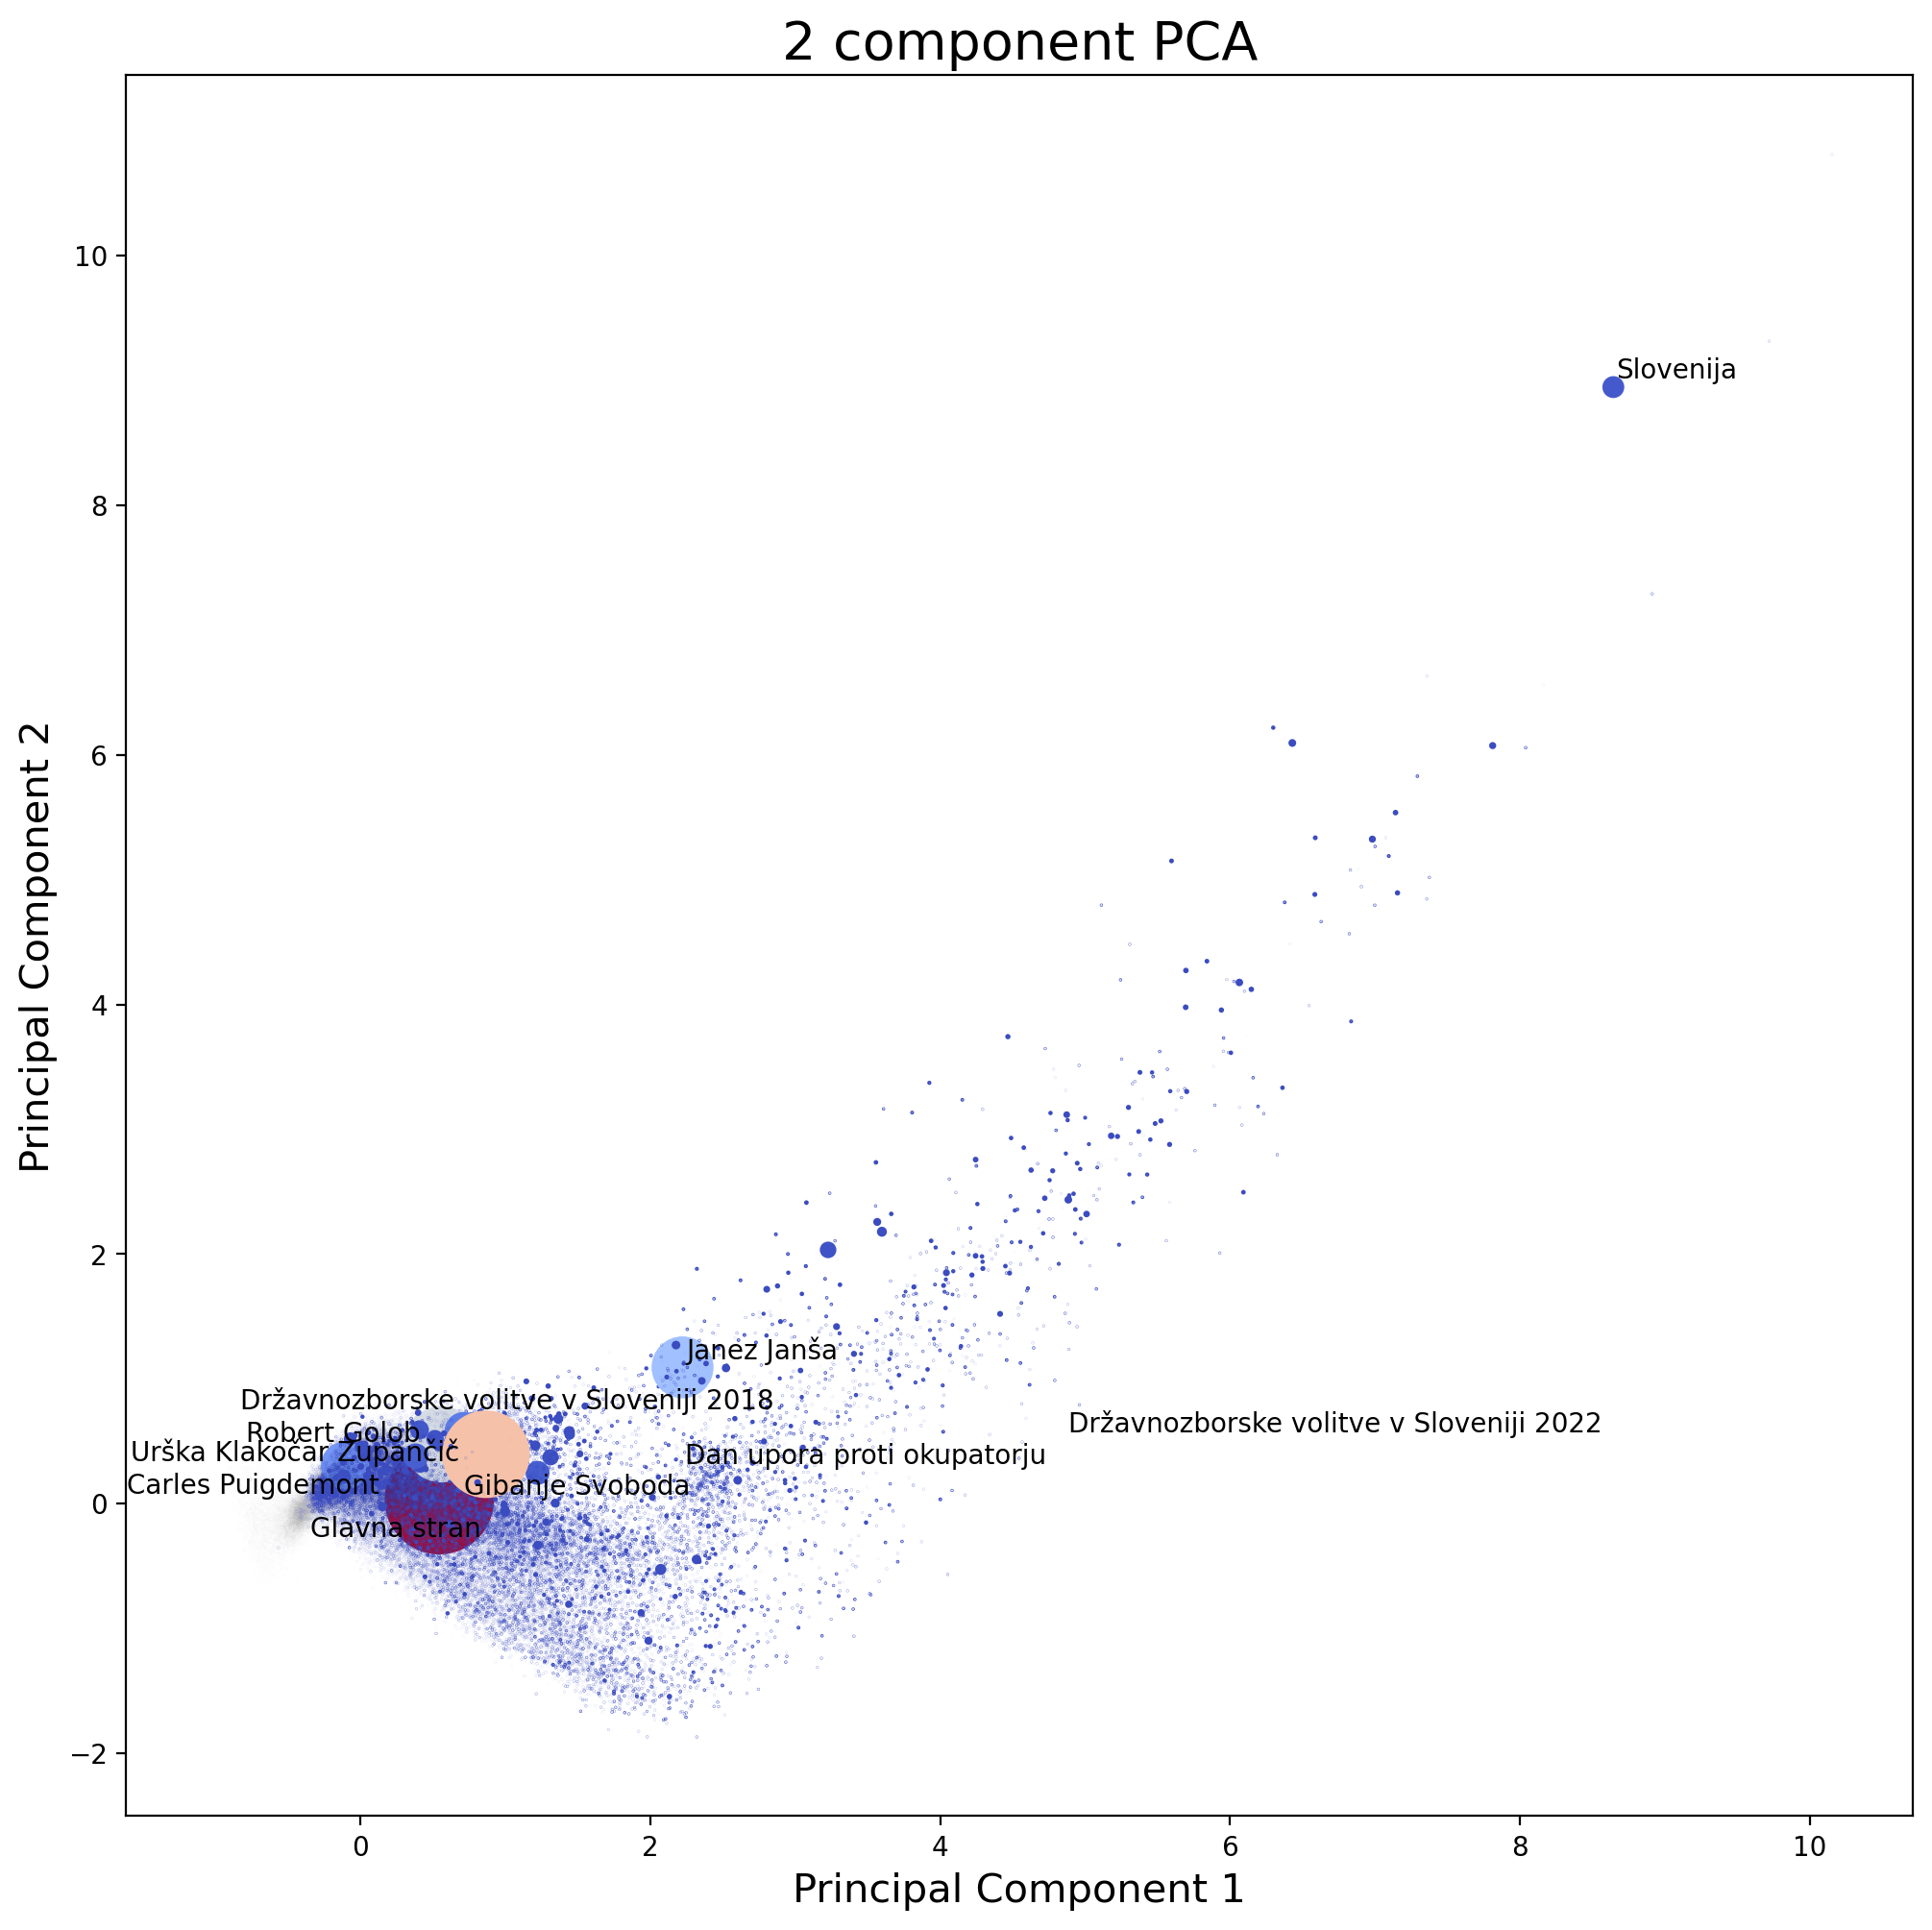

In [162]:
plot_views(embeddings_truncated, num_views[2], "views_03.png")

In [172]:
plot_views(embeddings_truncated, num_views[3], "views_04.png")